## 1. Get data from acled

## 2. Create Knowledge Graph in Neo4j

In [2]:
# # ###########################################################################################
from neo4j import GraphDatabase
import pandas as pd, numpy as np
from tqdm.auto import tqdm


/Users/ferranboadabergada/opt/anaconda3/envs/thesis_copy/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# # ###########################################################################################

# ============================================================
#  ACLED CSV  ➜  Neo4j loader  (Year–Month–Day hierarchy)
# ============================================================

neo4j_auth = "" # PASTE AUTH
neo4j_password = "" # PASTE PASSWORD
MISTRAL_KEY = "" # PASTE MISTRAL API KEY
CSV_FILE = "acled_data_Georgia.csv"
BOLT_URI = "bolt://localhost:7687"
USER, PWD = neo4j_auth, neo4j_password
BATCH     = 500

# ---------- dataframe prep ----------------------------------
df = pd.read_csv(CSV_FILE, low_memory=False)

In [4]:
# # ###########################################################################################

# ============================================================
# check the state of graph and loading wrapers
# ============================================================

# Load the graph from the acled-structured-CSV file into Neo4j
def load_graph(uri, user, pwd, acled_df):
    df = acled_df.copy()
    BOLT_URI = uri
    USER, PWD = user, pwd

    df["event_date"] = pd.to_datetime(df["event_date"])
    df["year"] = df["event_date"].dt.year.astype(int)
    df["month"] = df["event_date"].dt.month.astype(int)
    df["day"] = df["event_date"].dt.day.astype(int)
    df["date_int"] = df["event_date"].dt.strftime("%Y%m%d").astype(int)

    def nz(v): return None if pd.isna(v) else str(v).strip()

    def to_dict(r):
        return dict(
            id=r.event_id_cnty,
            date_str=r.event_date.strftime("%Y-%m-%d"),
            year=int(r.year),
            month=int(r.month),
            day=int(r.day),
            date_int=int(r.date_int),
            fatalities=0 if pd.isna(r.fatalities) else int(r.fatalities),
            notes=nz(r.notes) or "",
            admin1=nz(r.admin1),
            country=nz(r.country),
            lat=None if pd.isna(r.latitude) else float(r.latitude),
            lon=None if pd.isna(r.longitude) else float(r.longitude),
            etype=nz(r.event_type),
            actor1=nz(r.actor1),
            inter1=nz(r.inter1),
            actor2=nz(r.actor2),
            inter2=nz(r.inter2)
        )

    driver = GraphDatabase.driver(BOLT_URI, auth=(USER, PWD))
    with driver.session() as s:
        # Constraints
        s.run("CREATE CONSTRAINT IF NOT EXISTS FOR (e:Event) REQUIRE e.id IS UNIQUE")
        s.run("CREATE CONSTRAINT IF NOT EXISTS FOR (a:Actor) REQUIRE a.name IS UNIQUE")
        s.run("CREATE CONSTRAINT IF NOT EXISTS FOR (g:ActorGroup) REQUIRE g.name IS UNIQUE")
        s.run("CREATE CONSTRAINT IF NOT EXISTS FOR (t:EventType) REQUIRE t.code IS UNIQUE")
        s.run("CREATE CONSTRAINT IF NOT EXISTS FOR (s:State) REQUIRE s.admin1 IS UNIQUE")
        s.run("CREATE CONSTRAINT IF NOT EXISTS FOR (y:Year) REQUIRE y.value IS UNIQUE")
        s.run("CREATE CONSTRAINT IF NOT EXISTS FOR (m:Month) REQUIRE (m.year, m.value) IS UNIQUE")
        s.run("CREATE CONSTRAINT IF NOT EXISTS FOR (d:Day) REQUIRE d.date_int IS UNIQUE")

        # Static dimension nodes
        for row in df[["admin1", "country", "latitude", "longitude"]].drop_duplicates().itertuples(index=False):
            s.run("""
                MERGE (st:State {admin1:$a})
                ON CREATE SET st.lat=$lat, st.lon=$lon, st.country=$c
                SET st.country = $c
            """, a=row.admin1, lat=row.latitude, lon=row.longitude, c=row.country)

        for et in df["event_type"].dropna().unique():
            s.run("MERGE (:EventType {code:$c})", c=et)

        for grp in pd.unique(df[["inter1", "inter2"]].values.ravel()):
            if pd.notna(grp) and grp:
                s.run("MERGE (:ActorGroup {name:$n})", n=grp)

        # Batch insert
        BATCH = 5000
        cypher = """
        UNWIND $rows AS row
        MERGE (y:Year {value:row.year})
        MERGE (m:Month {year:row.year, value:row.month})
        MERGE (y)-[:HAS_MONTH]->(m)
        MERGE (d:Day {year:row.year, month:row.month, value:row.day, date_int:row.date_int})
        MERGE (m)-[:HAS_DAY]->(d)

        MERGE (e:Event {id:row.id})
          ON CREATE SET
            e.date = date(row.date_str),
            e.year = row.year,
            e.month = row.month,
            e.day = row.day,
            e.date_int = row.date_int,
            e.fatalities = row.fatalities,
            e.notes = row.notes,
            e.lat = row.lat,
            e.lon = row.lon,
            e.country = row.country

        MERGE (e)-[:IN_YEAR]->(y)
        MERGE (e)-[:ON_MONTH]->(m)
        MERGE (e)-[:ON_DAY]->(d)

        WITH e, row
        MATCH (s:State {admin1:row.admin1})
        MERGE (e)-[:IN_STATE]->(s)

        WITH e, row
        MATCH (t:EventType {code:row.etype})
        MERGE (e)-[:TYPE]->(t)

        WITH e, row
        FOREACH (_ IN CASE WHEN row.actor1 IS NOT NULL THEN [1] ELSE [] END |
          MERGE (a1:Actor {name:row.actor1})
          MERGE (e)-[:INVOLVES {role:'actor1'}]->(a1)
          FOREACH (_ IN CASE WHEN row.inter1 IS NOT NULL THEN [1] ELSE [] END |
            MERGE (g1:ActorGroup {name:row.inter1})
            MERGE (a1)-[:BELONGS_TO]->(g1)
          )
        )
        FOREACH (_ IN CASE WHEN row.actor2 IS NOT NULL THEN [1] ELSE [] END |
          MERGE (a2:Actor {name:row.actor2})
          MERGE (e)-[:INVOLVES {role:'actor2'}]->(a2)
          FOREACH (_ IN CASE WHEN row.inter2 IS NOT NULL THEN [1] ELSE [] END |
            MERGE (g2:ActorGroup {name:row.inter2})
            MERGE (a2)-[:BELONGS_TO]->(g2)
          )
        )
        """

        for start in tqdm(range(0, len(df), BATCH), desc="Loading events"):
            batch = [to_dict(r) for r in df.iloc[start:start + BATCH].itertuples()]
            s.run(cypher, rows=batch)

    print("✅ Graph loaded successfully")
    print_graph_info(BOLT_URI, USER, PWD)
    driver.close()
    
# Function to print the number of nodes and relationships in the graph
def print_graph_info(uri, user, pwd):
    print("Graph information:")

    driver = GraphDatabase.driver(uri, auth=(user, pwd))
    with driver.session() as session:
        stats = session.run(
            """
            MATCH (n)
            WITH count(n) AS nodes
            MATCH ()-[r]->()
            RETURN nodes, count(r) AS relationships
            """
        )
        #for row in stats:
        row = stats.single()
        if row is None or (row["nodes"] == 0 and row["relationships"] == 0):
            print("The graph is empty.")
        else:
            print(f"Nodes: {row['nodes']}, Relationships: {row['relationships']}")



# Print the number of nodes and relationships in the graph
# print_graph_info(BOLT_URI, USER, PWD)


# delete the graph and constraints
def delete_graph(uri, user, pwd):
    driver = GraphDatabase.driver(uri, auth=(user, pwd))
    with driver.session() as session:
        session.run("MATCH (n) DETACH DELETE n")
        for row in session.run("SHOW CONSTRAINTS"):
            session.run(f"DROP CONSTRAINT {row['name']}")
    print("Graph deleted successfully.")
    print_graph_info(uri, user, pwd)
    driver.close()


# Function to get event nodes from the graph
def get_event_nodes(uri, user, pwd, limit=10):
    driver = GraphDatabase.driver(uri, auth=(user, pwd))
    with driver.session() as session:
        result = session.run(
            "MATCH (e:Event) "
            "RETURN e.id AS id, e.date AS date, e.notes AS notes "
            "LIMIT $limit",
            limit=limit
        )
        for record in result:
            print(f"Event ID: {record['id']}, Date: {record['date']}, Notes: {record['notes']}")
    driver.close()

In [68]:
print_graph_info(BOLT_URI, USER, PWD)
# 
# delete_graph(BOLT_URI, USER, PWD)
#load_graph(BOLT_URI, USER, PWD, df)
get_event_nodes(BOLT_URI, USER, PWD, limit=10)

Graph information:
The graph is empty.


#  3. Extraction + Summarization

In [56]:

# # ###########################################################################################

import ollama
import requests

# Function to ask a local Ollama model or a remote LLM API
def ask_llm(
    prompt,
    ollama_model='tinydolphin',
    mistral_model='mistral-small-latest',
    temperature=0.7,
    max_tokens=1000,
    provider='mistral',
    api_key=MISTRAL_KEY, # PASTE KEY
    base_url="https://api.mistral.ai/v1/chat/completions",
    previous_messages=None
):
    """
    Unified function to call either a local Ollama model or a remote LLM API (e.g., Mistral).
    
    Args:
        prompt: The current user prompt string.
        ollama_model: Model name for Ollama.
        mistral_model: Model name for Mistral.
        temperature: Sampling temperature.
        max_tokens: Max tokens to generate.
        provider: 'ollama' for local, 'mistral' for remote.
        api_key: Required for remote providers like Mistral.
        base_url: Endpoint for remote API.
        previous_messages: List of prior messages for conversation context.
    
    Returns:
        The model's text response.
    """

    if provider == 'ollama':
        # Local Ollama call
        messages = previous_messages if previous_messages else []
        messages.append({"role": "user", "content": prompt})
        response = ollama.chat(
            model=ollama_model,
            messages=messages,
            options={"temperature": temperature}
        )
        return response['message']['content']

    elif provider == 'mistral':
        if not api_key or not base_url:
            raise ValueError("For Mistral provider, both api_key and base_url must be provided.")
        
        headers = {
            'Content-Type': 'application/json',
            'Authorization': f"Bearer {api_key}"
        }

        messages = previous_messages if previous_messages else []
        messages.append({"role": "user", "content": prompt})

        payload = {
            "model": mistral_model,
            "messages": messages,
            "temperature": temperature,
            "max_tokens": max_tokens
        }
        
        response = requests.post(base_url, headers=headers, json=payload)

        if response.status_code == 200:
            return response.json()["choices"][0]["message"]["content"]
        else:
            raise RuntimeError(f"API request failed: {response.status_code} - {response.text}")
    
    else:
        raise ValueError(f"Unknown provider: {provider}")
    


# Function to ask a local Ollama model
def ask_ollama(prompt, model='tinydolphin', temperature=0.7):
    """Send prompt to local Ollama model with adjustable temperature."""
    response = ollama.chat(
        model=model,
        messages=[{"role": "user", "content": prompt}],
        options={"temperature": temperature}
    )
    return response['message']['content']

# Function to query events by year, month, and country and state and type optionally
def query_events(uri, user, pwd, year, month, country, event_type=None, state=None, max_results=5000):
    """
    Query events by year, month, country, and optionally state and event type.
    Returns a bullet-point summary of the top events, sorted by fatalities and date.
    """
    driver = GraphDatabase.driver(uri, auth=(user, pwd))

    cypher = """
    MATCH (e:Event)-[:TYPE]->(t:EventType),
          (e)-[:IN_STATE]->(s:State)
    WHERE e.year = $yr AND e.month = $mo
      AND s.country = $country
      {state_filter}
      {event_type_filter}
    RETURN e.id AS id, toString(e.date) AS date,
           s.admin1 AS state, t.code AS type,
           e.fatalities AS fat, e.notes AS note
    ORDER BY fat DESC, date ASC
    LIMIT $limit
    """

    # Add dynamic filter blocks
    event_type_filter = "AND t.code = $etype" if event_type else ""
    state_filter = "AND s.admin1 = $state" if state else ""

    # Inject dynamic Cypher
    final_query = cypher.replace("{event_type_filter}", event_type_filter)
    final_query = final_query.replace("{state_filter}", state_filter)

    with driver.session() as session:
        params = {
            "yr": year,
            "mo": month,
            "country": country,
            "limit": max_results
        }
        if event_type:
            params["etype"] = event_type
        if state:
            params["state"] = state

        rows = session.run(final_query, **params).data()

    driver.close()

    if not rows:
        filter_info = f"{event_type or 'any type'}"
        if state:
            filter_info += f" in {state}"
        return "", 0

    df = pd.DataFrame(rows)

    bullets = "\n".join(
        f"- ({r.id}) {r.date}, {r.state}: {r.type.lower()} – {r.fat} fat. {r.note}"
        for r in df.itertuples()
    )

    return bullets, len(df)

# Function to build prompt from event data
def build_actor_prompt(bullets, tot_events, tot_fat, uniq_states, actor_name):
    prompt = f"""You are an analyst writing a conflict-early-warning brief.
Summarise key developments involving *{actor_name}* in Mexico, February 2025.

Context
-------
Total events : {tot_events}
Fatalities    : {tot_fat}
States        : {uniq_states}

Key events
----------
{bullets}

Task
----
Provide a concise summary. Cite Event IDs in parentheses.  Do **not** invent facts.
"""
    return prompt

# Function to build prompt to summarize events for a specific country, event type and month
def build_summary_prompt(country="Mexico", event_type="Protests", month=2, year=2025, bullets="", context=""):
    month_dict = {
        1: "January",
        2: "February",
        3: "March",
        4: "April",
        5: "May",
        6: "June",
        7: "July",
        8: "August",
        9: "September",
        10: "October",
        11: "November",
        12: "December"
    }

    if bullets == "" and context == "":
        prompt = ""
# ---------------------------------------------------------------------------------------
    elif bullets != "" and context == "":
        prompt   = f"""You are an analyst writing a conflict-early-warning brief.
Summarise key developments of type {event_type} in {country}, {month_dict[month]} {year}.

Key events
----------
{bullets}

Task
----
Provide a concise summary. Cite Event IDs in parentheses.  Do **not** invent facts.
"""
# ---------------------------------------------------------------------------------------
    elif bullets == "" and context != "":
        prompt   = f"""You are an analyst writing a conflict-early-warning brief.
Explain that there were no new events of type {event_type} in {country}, {month} {year}, but provide context.

Context
-------
Key developments in previous month : {context}



Task
----
Provide a concise summary. Cite Event IDs in parentheses.  Do **not** invent facts.
"""
# ---------------------------------------------------------------------------------------
    else:

        prompt = f"""You are an analyst writing a conflict-early-warning brief.
Summarise key developments of type {event_type} in {country}, {month} {year}.

Context
-------
Key developments in previous month : {context}


Key events
----------
{bullets}

Task
----
Provide a concise summary. Cite Event IDs in parentheses.  Do **not** invent facts.
"""
    return prompt


# Function to summarize events using build_summary_prompt 
def summarize_events(uri, user, pwd, llm_provider = "mistral", country="Mexico", event_type=None, month=2, year=2025, max_results=5000, context="", temperature = 0.7, max_tokens=1000):
    
    bullets, tot_events = query_events(
    uri=uri,
    user=user,
    pwd=pwd,
    year=year,
    month=month,
    country=country,
    event_type=event_type,
    max_results=max_results
)    
    
    print("total events found:", tot_events)
    prompt = build_summary_prompt(country, event_type, month, year, bullets, context)
    if prompt == "":
        summary = "No events found for the specified filters."
    else:
        summary = ask_llm(prompt, provider= llm_provider, temperature=temperature, max_tokens=max_tokens)

    return summary, bullets





In [99]:
paragraph_1, bullets= summarize_events(
    uri=BOLT_URI,
    user=USER,
    pwd=PWD,
    country="Mexico",
    month=2,
    year=2025,
    context="",
    temperature=0.7
)


total events found: 156


In [100]:
import textwrap
print("--------------------Summary of events: ---------------------")
print(textwrap.fill(paragraph_1, width=80))
print("\n\n----------------Bullet points: ---------------------")
print(textwrap.fill(bullets, width=80))

--------------------Summary of events: ---------------------
### Summary of Key Developments in Mexico, February 2025  **Violence Against
Civilians:** - Multiple incidents of violence against civilians were reported
throughout February 2025. Notable events include:   - **Ecatepec de Morelos:**
Several incidents resulted in fatalities, including three people killed on
February 21 and two on February 15 (MEX99884, MEX99444).   - **Ciudad de Mexico
- Iztapalapa:** Three people were killed in a drive-by shooting on February 27
(MEX100887).   - **Santa Cruz Atizapan and Ciudad Lopez Mateos:** Multiple
incidents on February 19 resulted in fatalities, including two gas station
employees killed in each location (MEX99734, MEX99735).   - **Chalco de Diaz
Covarrubias:** Two drive-by shootings on February 21 and 22 resulted in
fatalities (MEX99883, MEX100087).  **Protests and Demonstrations:** - Various
protests occurred across Mexico, addressing a range of issues:   - **Ciudad de
Mexico:** Multi

# 4. (abstractive) Summary evaluation. Prompt tuning

#### - Content evaluation: respond questions from summaries using the corpus (hallucination) + other way (importance selection or coverage, not critical for short summaries) + semantic similarity across subtypes?. analogy: PRECISION / RECALL weighted score. (similar to QAGS). Precision is preferred bc of size independence and cost of false positives; false negatives are also costly but can be controlled through severity score
#### - Format evaluation: human judge or llm-as-judge (similar to G-score)
#### - Measurable variables: corpus length, number of steps (subtype summaries), prompt, temperature, previous context, countries, model. Full graphRAG methodology vs plain (benchmark)

## 4.1. Evaluation

In [6]:
# # ###########################################################################################

# Function to summarize from a full csv file in dataframe format
def summarize_from_csv(df, llm_provider = "mistral", country="Mexico", event_type=None, month=2, year=2025, max_results=5000, context="", temperature = 0.7, max_tokens=1000):    
    #df = pd.read_csv(csv_file)
    # extract the notes column from the csv as text string
    notes_text = "\n".join(df['notes'].dropna().astype(str).tolist())
    prompt = build_summary_prompt(country, event_type, month, year, notes_text, context)
    if prompt == "":
        summary = "No events found for the specified filters."
    else:
        summary = ask_llm(prompt, provider= llm_provider, temperature=temperature, max_tokens=max_tokens)

    return summary



In [7]:
# # ###########################################################################################

# test summary. simulate a summary for February 2025 in Mexico of several political events and some casualties
test_summary = """In February 2025, Mexico experienced a notable increase in political unrest, largely driven by proposed electoral reforms and public dissatisfaction with government transparency. The ruling National Sovereignty Party (NSP) introduced a controversial bill to restructure the National Electoral Institute (INE), sparking widespread protests in major cities.
On February 5th, more than 40,000 demonstrators gathered in Mexico City’s Zócalo Square to oppose the bill, which would allow political appointments to the INE. Protesters, including students, journalists, and opposition figures, warned of threats to electoral integrity. While largely peaceful, the event ended in a minor clash with police near the Senate building, resulting in 12 arrests and a few injuries.
In Monterrey, on February 8th, tensions rose when labor unions organized a protest against privatization of public services. The demonstration turned violent when riot police attempted to disperse the crowd, leading to 20 reported injuries. The local government blamed “organized agitators,” though civil rights groups condemned the police response.
Further south, rural protests emerged in Chiapas and Oaxaca, where indigenous communities blocked highways and government offices to demand land rights and education investment. These protests remained largely peaceful but highlighted ongoing disparities and mistrust toward federal policies.
Meanwhile, in Guadalajara, a coalition of mayors issued a public statement on February 15th urging the president to delay the electoral reform bill. They warned that unilateral changes could damage trust in democratic institutions, especially ahead of the 2026 national elections.
On February 20th, a teachers’ strike in Puebla over delayed salaries led to the temporary closure of over 300 schools. Though no violence was reported, parents and local officials expressed concern about the disruption to education during an already tense political moment.
By month’s end, over 90 protests had been recorded across at least 18 states, with civil society organizations urging the government to open dialogue with opposition parties and grassroots groups. While President Ordoñez remained firm in his support of the reforms, mounting public pressure suggested that legislative negotiations may be reconsidered in the coming weeks.
"""

# Function to create multiple-choice questions from a summary
def create_questions_from_summary(summary, num_questions=10, previous_questions=None):
    """
    Generate multiple-choice questions and answers in structured JSON format from a summary.
    
    Args:
        summary (str): The input summary to generate questions from.
        num_questions (int): Number of questions to generate.
        previous_questions (list): Optional list of previously asked questions to avoid repetition.

    Returns:
        list: Parsed list of new questions (or error info).
    """
    previous_prompt = ""
    if previous_questions:
        previous_q_texts = [q["question"] for q in previous_questions if "question" in q]
        formatted_previous = "\n".join(f"- {q}" for q in previous_q_texts)
        previous_prompt = f"""
The following questions have already been asked and MUST NOT be repeated:

{formatted_previous}
"""

    prompt = f"""
You are a multiple-choice question generation AI.

{previous_prompt}

Based on the following summary, generate exactly {num_questions} multiple choice questions in JSON format.
Each question should be clear, concise, and test comprehension of the summary content.

Each question object must include:
- "question": the question text
- "options": a list of 4 plausible answers (strings)
- "correct_answer": one of the 4 options, marked as the correct one

The output must be a valid JSON object preceded by a "json" tag.
Output format:
json[
  {{
    "question": "...",
    "options": ["...", "...", "...", "..."],
    "correct_answer": "..."
  }},
  ...
]

Summary:
{summary}
"""

    try:
        response = ask_llm(prompt, provider="mistral", temperature=0.7, max_tokens=1500)
        questions = read_json(response)
        return questions
    except Exception as e:
        return {"error": str(e), "raw_output": response}

# Function to create a total number of questions in batches
def create_total_questions(summary, total_questions=40, batch_size=10):
    """
    Generate a specified total number of multiple-choice questions from a summary,
    using create_questions_from_summary in batches to avoid repetition.

    Args:
        summary (str): The input summary to generate questions from.
        total_questions (int): Total number of questions desired.
        batch_size (int): Number of questions to generate per batch (default: 10).

    Returns:
        list: A combined list of all generated questions.
    """
    all_questions = []

    while len(all_questions) < total_questions:
        step = len(all_questions) + 1
        remaining = total_questions - len(all_questions)
        current_batch_size = min(batch_size, remaining)

        new_questions = create_questions_from_summary(
            summary,
            num_questions=current_batch_size,
            previous_questions=all_questions
        )

        # Handle error or unexpected output. If error then the questions are retrieved again
        if isinstance(new_questions, dict) and "error" in new_questions:
          #  return new_questions  # Return the error info directly
            print( f"Error found. Retrying to generate questions at step {step}.")
        else: 

            all_questions.extend(new_questions)

    return all_questions



def read_json(response: str):
    import json

    """
    Extracts and parses the JSON content from a response string 
    that starts with 'json[' and ends with ']'.

    Parameters:
    - response (str): The full string containing the 'json[' block.

    Returns:
    - List[dict]: Parsed JSON list of dictionaries.
    """
    start = response.find("json[")
    if start == -1:
        raise ValueError("No 'json[' tag found in response")

    json_start = start + len("json")
    response = response[json_start:].strip()

    if not (response.startswith('[') and response.endswith(']')):
        raise ValueError("JSON block not formatted correctly")

    return json.loads(response)

In [8]:
# # ###########################################################################################

# Generate questions from the test summary
questions = create_questions_from_summary(test_summary, num_questions=10)
# Print the generated questions
import json
print("Generated Questions:")
print(json.dumps(questions, indent=2, ensure_ascii=False))

Generated Questions:
[
  {
    "question": "In which month and year did Mexico experience a notable increase in political unrest?",
    "options": [
      "January 2024",
      "February 2025",
      "March 2026",
      "December 2024"
    ],
    "correct_answer": "February 2025"
  },
  {
    "question": "What was the primary driver of the political unrest in Mexico in February 2025?",
    "options": [
      "Economic recession",
      "Proposed electoral reforms",
      "Natural disasters",
      "Healthcare reforms"
    ],
    "correct_answer": "Proposed electoral reforms"
  },
  {
    "question": "Which party introduced a controversial bill to restructure the National Electoral Institute (INE)?",
    "options": [
      "National Sovereignty Party (NSP)",
      "Opposition Party",
      "Labor Party",
      "Green Party"
    ],
    "correct_answer": "National Sovereignty Party (NSP)"
  },
  {
    "question": "Where did over 40,000 demonstrators gather to oppose the bill on February 5

In [9]:
# # ###########################################################################################

# evaluate questions. Avoid biasing results including answers in same request!! Use fewshot and tags
def evaluate_questions(questions_json, test_corpus, manual=False):
    """
    Evaluate the generated json questions against a test corpus.
    Returns the evaluation result.
    """
    questions_only = [
    {
        "question": item["question"],
        "options": item["options"]
    }
    for item in questions_json
    ]    
    solutions_only = [
    {
        "question": item["question"],
        "correct_answer": item["correct_answer"]
    }
    for item in questions_json
    ]
    responder_prompt = f"""   
    You are taking a multiple-choice test based on a corpus of text.
    Your task is to answer each of the questions to the best of your ability.
    Your output must be a valid JSON object preceded by a "json" tag, with
    your answer to each question.

    Output format:
    json[
      {{
        "question": "...",
        "options": ["...", "...", "...", "..."],
        "answer": "..."
      }},
      ...
    ]

    Corpus text: {test_corpus}
    Questions: {questions_only}
    """
    try:
        # Ask the LLM to answer the questions
        answers = ask_llm(responder_prompt, provider="mistral", temperature=0.2, max_tokens=1500)
        answers_json = read_json(answers)
        #print("Test answered successfully by LLM.")
    except Exception as e:
        return {"error": str(e), "raw_output": answers}
    
    answers_json = [
    {
        "question": item["question"],
        "answer": item["answer"]
    }
    for item in answers_json
    ]

    evaluator_prompt = f"""
    You are evaluating multiple-choice test answers.
    Your task is to assess the correctness of each answer based on the provided solutions.
    Your output must be the total number of correct answers, preceded by a "result" tag.

    Output format:
    result <number_of_correct_answers>

    Example of output format:
    result 5
    
    Answers: {answers_json}
    Solutions: {solutions_only}
    """
    # If manual evaluation is requested, skip LLM evaluation
    if manual==False:

        try:
            # Ask the LLM to evaluate the answers
            result = ask_llm(evaluator_prompt, provider="mistral", temperature=0.2, max_tokens=5)
            # Extract the number of correct answers from the result
            result = int(result.split("result ")[1].strip())
            #print("Test evaluated successfully by LLM. Result: ", result)
        except Exception as e:
            return {"error": str(e), "raw_output": result}
    else:
    
        # manually compare answers from answers_json and solutions_only
        correct_count = 0
        for answer in answers_json:
            for solution in solutions_only:
                if answer["question"] == solution["question"]:
                    if answer["answer"] == solution["correct_answer"]:
                        correct_count += 1
        result = correct_count
        #print("Test evaluated successfully manually. Result: ", result)




    return result


In [10]:
# # ###########################################################################################

# test metric
# Evaluate the generated questions against a random summary about other topics
random_summary = """In February 2025, the global tech industry saw significant advancements in AI and quantum computing. Major companies announced breakthroughs in machine learning algorithms, enhancing data processing speeds by 50%. Meanwhile, quantum computers demonstrated their potential by solving complex problems previously deemed unsolvable. This period marked a pivotal shift towards more efficient and powerful computing technologies."""
# Evaluate with the same text
result = evaluate_questions(questions, test_summary, manual=False)
# Evaluate with completely different text
result_random = evaluate_questions(questions, random_summary, manual=False)

# Print the evaluation results
print("Evaluation result on test summary:", result)
print("Evaluation result on random summary:", result_random)

Evaluation result on test summary: {'error': 'list index out of range', 'raw_output': 'To determine the number of'}
Evaluation result on random summary: {'error': 'list index out of range', 'raw_output': 'Based on the provided answers'}


In [11]:
# # ###########################################################################################

from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

# Function to evaluate hallucination rate in a summary with respect to a corpus
def evaluate_hallucination(summary, test_corpus, num_questions=-1, manual=False, iterations=1):
    """
    Evaluate hallucination in a summary by generating multiple-choice questions
    and testing them against a trusted corpus.

    Args:
        summary (str): The summary to evaluate.
        test_corpus (str): The trusted reference notes.
        num_questions (int): Total number of questions to generate. Default is the max amount given the size.
        manual (bool): If True, evaluate manually instead of using LLM.
        iterations (int): Number of times each batch of questions is answered.

    Returns:
        dict: Hallucination rate and related stats.
    """
    
    # Step 1: Estimate how many questions are appropriate
    num_sentences = summary.count('.') + summary.count('!') + summary.count('?') + summary.count(',') + 1
    if num_sentences < num_questions:
        num_questions = num_sentences
    
    # Deal with the number of questions
    if num_questions < 0:
        num_questions = num_sentences

    # Step 2: Round to nearest multiple of 10
    if num_questions % 10 != 0:
        if num_questions % 10 >= 5:
            num_questions = (num_questions // 10 + 1) * 10
        else:
            num_questions = (num_questions // 10) * 10

    # Step 3: Generate the questions
    questions_json = create_total_questions(summary, total_questions=num_questions, batch_size=10)

    if isinstance(questions_json, dict) and "error" in questions_json:
        return questions_json  # Early exit on generation failure

    # Step 4: Stack into batches of 10
    stacked_questions = [questions_json[i:i+10] for i in range(0, len(questions_json), 10)]

    # Step 5: Evaluate each batch multiple times
    total_questions = 0
    total_correct = 0
    failed_batches = 0

    with ThreadPoolExecutor() as executor:
        futures = [
            executor.submit(evaluate_questions, batch, test_corpus, manual=manual)
            for _ in range(iterations)
            for batch in stacked_questions
        ]

        for future in tqdm(as_completed(futures), total=len(futures), desc="Evaluating"):
            try:
                result = future.result()
                if isinstance(result, dict) and "error" in result:
                    failed_batches += 1
                    continue
                total_correct += result
                total_questions += 10  # Each batch is 10 questions
            except Exception:
                failed_batches += 1
                continue

    hallucination_rate = 1 - (total_correct / total_questions) if total_questions > 0 else None

    print("Hallucination rate:", hallucination_rate)    


    return {
        "hallucination_rate": hallucination_rate,
        "total_questions": total_questions,
        "correct_answers": total_correct,
        "incorrect_answers": total_questions - total_correct,
        "failed_batches": failed_batches,
        "iterations_per_batch": iterations,
        "total_batches": len(stacked_questions)
    }

In [120]:
hallucination_result = evaluate_hallucination(
    summary=test_summary,
    test_corpus=test_summary,
    num_questions=20,
    manual=True,
    iterations=2
)
# Print the hallucination evaluation result
print("Hallucination Evaluation Result:")
print(json.dumps(hallucination_result, indent=2, ensure_ascii=False))

Error found. Retrying to generate questions at step 11.


Evaluating: 100%|██████████| 4/4 [00:09<00:00,  2.30s/it]

Hallucination rate: 0.0
Hallucination Evaluation Result:
{
  "hallucination_rate": 0.0,
  "total_questions": 40,
  "correct_answers": 40,
  "incorrect_answers": 0,
  "failed_batches": 0,
  "iterations_per_batch": 2,
  "total_batches": 2
}


In [12]:
# # ###########################################################################################

# Compare different summarization methods using the metric

test_csv = "acled_data_Georgia.csv"
neo4j_auth = "prova"
neo4j_password = "provaprova"
BOLT_URI = "bolt://localhost:7687"
USER, PWD = neo4j_auth, neo4j_password
BATCH     = 500
# Load the test CSV file into a DataFrame
df = pd.read_csv(test_csv, low_memory=False)

In [17]:
# # ###########################################################################################

# Subsample the corpus of events corresponding to the summarized month
# Create a corpus of events from the notes column using only event_date in february
df['event_date'] = pd.to_datetime(df['event_date'])
df['month'] = df['event_date'].dt.month.astype(int)
df_february = df[(df['year'] == 2025) & (df['month'] == 2)]

georgia_corpus = "\n".join(df_february['notes'].dropna().astype(str).tolist())
import textwrap
#print("--------------------Corpus of events: ---------------------")
#print(textwrap.fill(georgia_corpus, width=80))

# count tokens (only approximately)
def count_tokens(text):
    """Estimate the number of tokens in a text string."""
    return len(text.split())
# Count tokens in the corpus
corpus_tokens = count_tokens(georgia_corpus)
print(f"Total tokens in corpus: {corpus_tokens}")

Total tokens in corpus: 1656


In [82]:
plain_summary = summarize_from_csv( df, llm_provider="mistral", country="Georgia", event_type=None, month=2, year=2025, max_results=5000, context="", temperature=0.7, max_tokens=1000)
print("\n--------------------Plain summary: ---------------------")
print(textwrap.fill(plain_summary, width=80))


--------------------Plain summary: ---------------------
### Summary of Key Developments in Georgia, February 2025  **Pro-EU Protests and
Civil Unrest:** - **Ongoing Pro-EU Protests:** Throughout February 2025, pro-EU
protesters consistently blocked traffic on Rustaveli Avenue in Tbilisi, often
accompanied by rallies outside the Georgian Public Broadcaster. These protests
were part of a sustained movement demanding closer ties with the European Union
and political reforms (e.g., 28 February, 27 February, 26 February). - **Violent
Incidents:** Several incidents of violence were reported, including attacks on
activists and journalists. For instance, two women activists were attacked and
beaten on 5 March, and a journalist was attacked on 12 May (5 March, 12 May). -
**Police Interventions:** Police frequently intervened in protests, sometimes
leading to arrests and scuffles. For example, on 2 February, police beat and
arrested protesters attempting to block traffic on Aghmashenebeli Alle

In [118]:
graph_summary,bullets = summarize_events(
    uri=BOLT_URI,
    user=USER,
    pwd=PWD,
    country="Georgia",
    month=2,
    year=2025,
    context="",
    temperature=0.7
) 

total events found: 69


In [121]:
# Evaluate plain_Summarization
plain_summary_eval = evaluate_hallucination(
    summary=plain_summary,
    test_corpus=georgia_corpus,
    num_questions=40,
    manual=True,
    iterations=2
)

graph_summary_eval = evaluate_hallucination(    
    summary=graph_summary,
    test_corpus=georgia_corpus,
    num_questions=40,
    manual=True,
    iterations=2
)

Evaluating: 100%|██████████| 8/8 [00:16<00:00,  2.08s/it]


Hallucination rate: 0.2142857142857143


Evaluating: 100%|██████████| 8/8 [00:12<00:00,  1.51s/it]

Hallucination rate: 0.050000000000000044


In [13]:
# # ###########################################################################################

#from concurrent.futures import ThreadPoolExecutor, as_completed
#from tqdm import tqdm
import re

# Evaluate format using LLM-as-judge
def format_judge(summary, length=500):
    """
    Evaluate the format of a summary using an LLM.
    
    Args:
        summary (str): The summary to evaluate.
        
    Returns:
        str: The evaluation result from the LLM.
    """
    prompt = f"""
You are an AI judge evaluating the format of a summary.
Your task is to evaluate the summary with a grade from 0 to 5. 
The maximum grade of 5 should be given if the summary follows the following format:

1. It should be concise and clear. (1 point)
2. It should be easy to read and understand. (1 point)
3. It should be written in a professional tone. (1 point)
4. It should not exceed {length} words approximately. (1 point)
5. It should be structured with clear paragraphs. (1 point)

For each of these criteria, assign a score from 0 to 1, where 0 means the summary does not meet the criteria at all, and 1 means it meets the criteria perfectly.
The total score is the sum of these individual scores, which should be between 0 and 5.

Summary to evaluate:
{summary}

Your output must be only the grade given to the summary, preceded by a "result" tag.

    Output format:
    result <grade_of_the_summary>

    Example of output format:
    result 5
"""
    try:
        result = ask_llm(prompt, provider="mistral", temperature=0.2, max_tokens=5)

        # Extract grade using regex
        match = re.search(r"result\s+(\d+)", result.lower())
        if match:
            return int(match.group(1))
        else:
            return {"error": "No valid grade found in response", "raw_output": result}
    except Exception as e:
        return {"error": str(e), "raw_output": result if 'result' in locals() else None}


def evaluate_format(summary, length=500, iterations=1):
    """
    Evaluate the format of a summary by asking an LLM judge.

    Args:
        summary (str): The summary to evaluate.
        length (int): Maximum length of the summary in words.
        iterations (int): Number of times to ask the LLM judge.

    Returns:
        dict: Evaluation result including average grade and total evaluations.
    """
    total_grade = 0
    completed = 0
    attempts = 0
    results = []

    def safe_call():
        try:
            result = format_judge(summary, length)
            if isinstance(result, dict) and "error" in result:
                return None
            return result
        except Exception:
            return None

    with tqdm(total=iterations, desc="Evaluating format") as pbar:
        while completed < iterations:
            with ThreadPoolExecutor() as executor:
                needed = iterations - completed
                futures = [executor.submit(safe_call) for _ in range(needed)]
                for future in as_completed(futures):
                    attempts += 1
                    grade = future.result()
                    if grade is not None:
                        total_grade += grade
                        completed += 1
                        results.append(grade)
                        pbar.update(1)
                    if completed >= iterations:
                        break

    average_grade = total_grade / iterations if iterations > 0 else None
    format_deviation = 1 - average_grade / 5 if average_grade is not None else None

    print("Format deviation rate:", format_deviation)

    return {
        "Format deviation rate": format_deviation,
        "average_grade": average_grade,
        "total_evaluations": iterations,
        "total_attempts": attempts,
        "individual_grades": results
    }


In [147]:
# Test format. Include context and test both metrics
plain_format_eval = evaluate_format(plain_summary, length=500, iterations=12)
graph_format_eval = evaluate_format(graph_summary, length=500, iterations=12)
test_format_eval = evaluate_format(test_summary, length=500, iterations=12)


Evaluating format: 100%|██████████| 12/12 [00:00<00:00, 29.72it/s]


Format deviation rate: 0.4


Evaluating format: 100%|██████████| 12/12 [00:00<00:00, 26.96it/s]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 12/12 [00:21<00:00,  1.78s/it]

Format deviation rate: 0.0


## 4.2. 1/3 Hallucination Test; vs size, vs method (graphrag/simple)

In [14]:
# # ###########################################################################################

# Evaluate summaries at different thresholds (corpus size, temperature, etc.)

# --------------------- Test 1. corpus size ---------------------

# load all the data available to the graph
df_mexico = pd.read_csv("acled_data_Mexico.csv", low_memory=False)
df_congo = pd.read_csv("acled_data_Congo.csv", low_memory=False)
df_georgia = pd.read_csv("acled_data_Georgia.csv", low_memory=False)
df_sudan = pd.read_csv("acled_data_Sudan.csv", low_memory=False)
# merge dataframes
df_all = pd.concat([df_mexico, df_congo, df_georgia, df_sudan], ignore_index=True)

load_graph(uri=BOLT_URI,user=USER,pwd=PWD,acled_df=df_all)


Loading events: 100%|██████████| 2/2 [00:02<00:00,  1.18s/it]

✅ Graph loaded successfully
Graph information:
Nodes: 9075, Relationships: 57701


In [173]:
# create a sample of pairs summary - corpus from different countries, months and types
countries = ["Mexico", "Georgia", "Democratic Republic of Congo", "Sudan"]
months = [1, 2, 3, 4, 5]
event_types = ["Protests", "Riots", "Violence against civilians", "Strategic developments", "Battles", "Explosions/Remote violence"]
# extract month from the event_date column
df_all['event_date'] = pd.to_datetime(df_all['event_date'])
df_all['month'] = df_all['event_date'].dt.month.astype(int)

# generate one summary for each country, month and type
import json

MAX_TOKENS_PLAIN_SUMM = 50000


discarded = []

summaries = []

for country in countries:
    for month in months:
        for event_type in event_types:

            # corpus for evaluation metrics
            corpus_df = df_all[
                (df_all['country'] == country) &
                (df_all['month'] == month) &
                (df_all['event_type'] == event_type)
            ]
            corpus_text = "\n".join(corpus_df['notes'].dropna().astype(str).tolist())
            corpus_tokens = count_tokens(corpus_text)

            # corpus for plain summarization: concat corpus_df and a random corpus of the same country and month and length
            # to increase noise before summarization (truncated without exceeding MAX_TOKENS for prompt)

            extra_events = min(corpus_tokens, MAX_TOKENS_PLAIN_SUMM - corpus_tokens) # do not exceed MAX_TOKENS_PLAIN_SUMM
            extra_events = extra_events  / 50  # 50 is the average number of tokens per event in the corpus

            # plain_corpus is the concatenation of the corpus_df and a random sample of extra_events events from the same country and month
            # that are not in corpus_df
            extra_pool = df_all[
            (df_all['country'] == country) &
            (df_all['month'] == month) &
            (df_all['event_type'] != event_type)
                ]

            n_extra = min(int(extra_events)+1, len(extra_pool))

            if n_extra > 0:
                extra_df = extra_pool.sample(n=n_extra, random_state=42)
                plain_corpus = pd.concat([corpus_df, extra_df], ignore_index=True)
            else:
                plain_corpus = corpus_df

            plain_corpus_tokens = count_tokens("\n".join(plain_corpus['notes'].dropna().astype(str).tolist()))

            try:
                #graphRAG method
                summary, bullets = summarize_events(
                    uri=BOLT_URI,
                    user=USER,
                    pwd=PWD,
                    country=country,
                    month=month,
                    year=2025,
                    context="",
                    temperature=0.7,
                    event_type=event_type,
                )

                # siumple summary
                plain_summary = summarize_from_csv(
                    plain_corpus,
                    country=country,
                    event_type=event_type,
                    month=month,
                    year=2025
                )
            except Exception as e:
                discarded.append({
                    "reason": "summarization_error",
                    "country": country,
                    "month": month,
                    "event_type": event_type,
                    "error": str(e)
                })
                print(f"⚠️ Failed summarization for {country}, {month}, {event_type} – {e}")
                continue

            summaries.append({
                "country": country,
                "month": month,
                "event_type": event_type,
                "graphRAG_summary": summary,
                "simple_summary": plain_summary,
                "corpus": corpus_text,
                "corpus_length": corpus_tokens,
                "plain_corpus_length": plain_corpus_tokens
            })

            print(f"✅ Summary for {country}, Month: {month}, Type: {event_type} – {corpus_tokens} tokens, {n_extra*50} extra tokens")
            
# Save to file
with open("summaries_sample_big.json", "w") as f:
    json.dump(summaries, f, indent=2)


total events found: 0
✅ Summary for Mexico, Month: 1, Type: Protests – 0 tokens, 0 extra tokens
total events found: 0
✅ Summary for Mexico, Month: 1, Type: Riots – 0 tokens, 0 extra tokens
total events found: 0
✅ Summary for Mexico, Month: 1, Type: Violence against civilians – 0 tokens, 0 extra tokens
total events found: 0
✅ Summary for Mexico, Month: 1, Type: Strategic developments – 0 tokens, 0 extra tokens
total events found: 0
✅ Summary for Mexico, Month: 1, Type: Battles – 0 tokens, 0 extra tokens
total events found: 0
✅ Summary for Mexico, Month: 1, Type: Explosions/Remote violence – 0 tokens, 0 extra tokens
total events found: 569
✅ Summary for Mexico, Month: 2, Type: Protests – 27595 tokens, 22450 extra tokens
total events found: 29
✅ Summary for Mexico, Month: 2, Type: Riots – 1369 tokens, 1400 extra tokens
total events found: 337
✅ Summary for Mexico, Month: 2, Type: Violence against civilians – 14912 tokens, 14950 extra tokens
total events found: 172
✅ Summary for Mexico, Mo

In [184]:
# Now evaluate the summaries from the summaries_sample.json using the format/hallucination metrics 
import json
# Load the summaries sample
with open("summaries_sample_big.json", "r") as f:
    summaries_sample = json.load(f)

# Evaluate each summary in the sample
results = []
for entry in summaries_sample:
    country = entry["country"]
    month = entry["month"]
    event_type = entry["event_type"]
    corpus = entry["corpus"]
    graphRAG_summary = entry["graphRAG_summary"]
    simple_summary = entry["simple_summary"]
    plain_corpus_length = entry["plain_corpus_length"]
    corpus_length = entry["corpus_length"]

    # Evaluate format
    # graph_format_eval = evaluate_format(graphRAG_summary, length=500, iterations=5)
    # simple_format_eval = evaluate_format(simple_summary, length=500, iterations=5)

    # Evaluate hallucination with 20 questions and 1 iterations
    graph_hallucination_eval = evaluate_hallucination(
        summary=graphRAG_summary,
        test_corpus=corpus,
        num_questions=20,
        manual=True,
        iterations=2
    )
    
    simple_hallucination_eval = evaluate_hallucination(
        summary=simple_summary,
        test_corpus=corpus,
        num_questions=20,
        manual=True,
        iterations=2
    )

    results.append({
        "country": country,
        "month": month,
        "event_type": event_type,
        "corpus_length": corpus_length,
        #"graphRAG_format": graph_format_eval,
        #"simple_format": simple_format_eval,
        "graphRAG_hallucination": graph_hallucination_eval,
        "simple_hallucination": simple_hallucination_eval
    })



Evaluating: 0it [00:00, ?it/s]


Hallucination rate: None


Evaluating: 0it [00:00, ?it/s]


Hallucination rate: None


Evaluating: 0it [00:00, ?it/s]


Hallucination rate: None


Evaluating: 0it [00:00, ?it/s]


Hallucination rate: None


Evaluating: 0it [00:00, ?it/s]


Hallucination rate: None


Evaluating: 0it [00:00, ?it/s]


Hallucination rate: None


Evaluating: 0it [00:00, ?it/s]


Hallucination rate: None


Evaluating: 0it [00:00, ?it/s]


Hallucination rate: None


Evaluating: 0it [00:00, ?it/s]


Hallucination rate: None


Evaluating: 0it [00:00, ?it/s]


Hallucination rate: None


Evaluating: 0it [00:00, ?it/s]


Hallucination rate: None


Evaluating: 0it [00:00, ?it/s]


Hallucination rate: None


Evaluating: 100%|██████████| 4/4 [00:12<00:00,  3.22s/it]


Hallucination rate: 0.17500000000000004


Evaluating: 100%|██████████| 4/4 [00:14<00:00,  3.65s/it]


Hallucination rate: 0.25


Evaluating: 100%|██████████| 4/4 [00:07<00:00,  1.92s/it]


Hallucination rate: 0.0


Evaluating: 100%|██████████| 4/4 [00:09<00:00,  2.35s/it]


Hallucination rate: 0.32499999999999996


Evaluating: 100%|██████████| 4/4 [00:12<00:00,  3.25s/it]


Hallucination rate: 0.15000000000000002


Evaluating: 100%|██████████| 4/4 [00:20<00:00,  5.09s/it]


Hallucination rate: 0.17500000000000004


Evaluating: 100%|██████████| 4/4 [00:08<00:00,  2.24s/it]


Hallucination rate: 0.0


Evaluating: 100%|██████████| 4/4 [00:08<00:00,  2.19s/it]


Hallucination rate: 0.275


Evaluating: 100%|██████████| 4/4 [00:11<00:00,  2.90s/it]


Hallucination rate: 0.0


Evaluating: 100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


Hallucination rate: 0.0


Evaluating: 100%|██████████| 4/4 [00:07<00:00,  1.92s/it]


Hallucination rate: 0.0


Evaluating: 100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


Hallucination rate: 0.0


Evaluating: 100%|██████████| 4/4 [00:11<00:00,  2.99s/it]


Hallucination rate: 0.525


Evaluating: 100%|██████████| 4/4 [00:17<00:00,  4.31s/it]


Hallucination rate: 0.0


Evaluating: 100%|██████████| 4/4 [00:17<00:00,  4.25s/it]


Hallucination rate: 0.0


Evaluating: 100%|██████████| 4/4 [00:16<00:00,  4.09s/it]


Hallucination rate: 0.0


Evaluating: 100%|██████████| 4/4 [00:16<00:00,  4.22s/it]


Hallucination rate: 0.09999999999999998


Evaluating: 100%|██████████| 4/4 [00:10<00:00,  2.63s/it]


Hallucination rate: 0.050000000000000044


Evaluating: 100%|██████████| 4/4 [00:10<00:00,  2.69s/it]


Hallucination rate: 0.4


Evaluating: 100%|██████████| 4/4 [00:18<00:00,  4.50s/it]


Hallucination rate: 0.050000000000000044


Evaluating: 100%|██████████| 4/4 [00:09<00:00,  2.43s/it]


Hallucination rate: 0.0


Evaluating: 100%|██████████| 4/4 [00:06<00:00,  1.66s/it]


Hallucination rate: 0.09999999999999998


Evaluating: 100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Hallucination rate: 0.0


Evaluating: 100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


Hallucination rate: 0.4


Evaluating: 100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Hallucination rate: 0.30000000000000004


Evaluating: 100%|██████████| 4/4 [00:12<00:00,  3.02s/it]


Hallucination rate: 0.07499999999999996


Evaluating: 100%|██████████| 4/4 [00:08<00:00,  2.15s/it]


Hallucination rate: 0.050000000000000044


Evaluating: 100%|██████████| 4/4 [00:19<00:00,  4.91s/it]


Hallucination rate: 0.050000000000000044


Evaluating: 100%|██████████| 4/4 [00:11<00:00,  2.90s/it]


Hallucination rate: 0.0


Evaluating: 100%|██████████| 4/4 [00:15<00:00,  3.84s/it]


Hallucination rate: 0.0


Evaluating: 100%|██████████| 4/4 [00:09<00:00,  2.40s/it]


Hallucination rate: 0.09999999999999998


Evaluating: 100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


Hallucination rate: 0.0


Evaluating: 100%|██████████| 4/4 [00:08<00:00,  2.19s/it]


Hallucination rate: 0.30000000000000004


Evaluating: 100%|██████████| 4/4 [00:08<00:00,  2.13s/it]


Hallucination rate: 0.09999999999999998


Evaluating: 100%|██████████| 4/4 [00:15<00:00,  3.89s/it]


Hallucination rate: 0.0


Evaluating: 100%|██████████| 4/4 [00:15<00:00,  3.91s/it]


Hallucination rate: 0.5


Evaluating: 100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Hallucination rate: 0.125


Evaluating: 100%|██████████| 4/4 [00:14<00:00,  3.61s/it]


Hallucination rate: 0.09999999999999998


Evaluating: 100%|██████████| 4/4 [00:10<00:00,  2.63s/it]


Hallucination rate: 0.09999999999999998


Evaluating: 100%|██████████| 4/4 [00:11<00:00,  2.99s/it]


Hallucination rate: 0.09999999999999998


Evaluating: 100%|██████████| 4/4 [00:11<00:00,  2.82s/it]


Hallucination rate: 0.050000000000000044


Evaluating: 100%|██████████| 4/4 [00:09<00:00,  2.38s/it]


Hallucination rate: 0.125


Evaluating: 100%|██████████| 4/4 [00:16<00:00,  4.11s/it]


Hallucination rate: 0.0


Evaluating: 100%|██████████| 4/4 [00:09<00:00,  2.30s/it]


Hallucination rate: 0.42500000000000004


Evaluating: 100%|██████████| 4/4 [00:13<00:00,  3.42s/it]


Hallucination rate: 0.0


Evaluating: 100%|██████████| 4/4 [00:16<00:00,  4.17s/it]


Hallucination rate: 0.050000000000000044


Evaluating: 100%|██████████| 4/4 [00:16<00:00,  4.01s/it]


Hallucination rate: 0.0


Evaluating: 100%|██████████| 4/4 [00:14<00:00,  3.55s/it]


Hallucination rate: None


Evaluating: 100%|██████████| 4/4 [00:06<00:00,  1.67s/it]


Hallucination rate: 0.0


Evaluating: 100%|██████████| 4/4 [00:07<00:00,  1.97s/it]


Hallucination rate: 0.0


Evaluating: 0it [00:00, ?it/s]


Hallucination rate: None


Evaluating: 100%|██████████| 4/4 [00:08<00:00,  2.07s/it]


Hallucination rate: 0.15000000000000002


Evaluating: 100%|██████████| 2/2 [00:06<00:00,  3.22s/it]


Hallucination rate: 0.09999999999999998


Evaluating: 100%|██████████| 2/2 [00:10<00:00,  5.12s/it]


Hallucination rate: 0.5


Evaluating: 0it [00:00, ?it/s]


Hallucination rate: None


Evaluating: 100%|██████████| 2/2 [00:10<00:00,  5.32s/it]


Hallucination rate: 0.09999999999999998


Evaluating: 0it [00:00, ?it/s]


Hallucination rate: None


Evaluating: 100%|██████████| 4/4 [00:06<00:00,  1.65s/it]


Hallucination rate: 0.050000000000000044


Evaluating: 0it [00:00, ?it/s]


Hallucination rate: None


Evaluating: 100%|██████████| 2/2 [00:07<00:00,  3.95s/it]


Hallucination rate: 0.19999999999999996


Evaluating: 100%|██████████| 4/4 [00:15<00:00,  3.91s/it]


Hallucination rate: 0.025000000000000022


Evaluating: 100%|██████████| 4/4 [00:09<00:00,  2.28s/it]


Hallucination rate: 0.050000000000000044


Evaluating: 0it [00:00, ?it/s]


Hallucination rate: None


Evaluating: 100%|██████████| 2/2 [00:11<00:00,  5.69s/it]


Hallucination rate: 0.0


Evaluating: 0it [00:00, ?it/s]


Hallucination rate: None


Evaluating: 100%|██████████| 2/2 [00:17<00:00,  8.92s/it]


Hallucination rate: None


Evaluating: 100%|██████████| 2/2 [00:07<00:00,  3.50s/it]


Hallucination rate: 0.09999999999999998


Evaluating: 100%|██████████| 4/4 [00:07<00:00,  1.99s/it]


Hallucination rate: 0.5


Evaluating: 0it [00:00, ?it/s]


Hallucination rate: None


Evaluating: 100%|██████████| 2/2 [00:08<00:00,  4.15s/it]


Hallucination rate: 0.0


Evaluating: 0it [00:00, ?it/s]


Hallucination rate: None


Evaluating: 100%|██████████| 2/2 [00:07<00:00,  3.52s/it]


Hallucination rate: 0.0


Evaluating: 100%|██████████| 4/4 [00:12<00:00,  3.15s/it]


Hallucination rate: 0.0


Evaluating: 100%|██████████| 4/4 [00:08<00:00,  2.02s/it]


Hallucination rate: 0.0


Evaluating: 100%|██████████| 4/4 [00:09<00:00,  2.45s/it]


Hallucination rate: 0.09999999999999998


Evaluating: 100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


Hallucination rate: 0.09999999999999998


Evaluating: 100%|██████████| 4/4 [00:09<00:00,  2.33s/it]


Hallucination rate: 0.0


Evaluating: 100%|██████████| 4/4 [00:09<00:00,  2.38s/it]


Hallucination rate: 0.19999999999999996


Evaluating: 0it [00:00, ?it/s]


Hallucination rate: None


Evaluating: 100%|██████████| 2/2 [00:06<00:00,  3.02s/it]


Hallucination rate: 0.0


Evaluating: 0it [00:00, ?it/s]


Hallucination rate: None


Evaluating: 100%|██████████| 2/2 [00:06<00:00,  3.11s/it]


Hallucination rate: 0.0


Evaluating: 0it [00:00, ?it/s]


Hallucination rate: None


Evaluating: 100%|██████████| 2/2 [00:05<00:00,  2.61s/it]


Hallucination rate: 0.0


Evaluating: 100%|██████████| 4/4 [00:06<00:00,  1.53s/it]


Hallucination rate: 0.0


Evaluating: 100%|██████████| 4/4 [00:06<00:00,  1.64s/it]


Hallucination rate: 0.0


Evaluating: 0it [00:00, ?it/s]


Hallucination rate: None


Evaluating: 100%|██████████| 4/4 [00:05<00:00,  1.49s/it]


Hallucination rate: 0.42500000000000004


Evaluating: 100%|██████████| 2/2 [00:06<00:00,  3.38s/it]


Hallucination rate: 0.09999999999999998


Evaluating: 100%|██████████| 4/4 [00:09<00:00,  2.48s/it]


Hallucination rate: 0.0


Evaluating: 0it [00:00, ?it/s]


Hallucination rate: None


Evaluating: 100%|██████████| 2/2 [00:06<00:00,  3.13s/it]


Hallucination rate: 0.0


Evaluating: 0it [00:00, ?it/s]


Hallucination rate: None


Evaluating: 100%|██████████| 2/2 [00:13<00:00,  6.80s/it]


Hallucination rate: 0.09999999999999998


Evaluating: 0it [00:00, ?it/s]


Hallucination rate: None


Evaluating: 100%|██████████| 2/2 [00:06<00:00,  3.44s/it]


Hallucination rate: 0.0


Evaluating: 100%|██████████| 4/4 [00:06<00:00,  1.70s/it]


Hallucination rate: 0.050000000000000044


Evaluating: 100%|██████████| 4/4 [00:11<00:00,  2.79s/it]


Hallucination rate: 0.125


Evaluating: 0it [00:00, ?it/s]


Hallucination rate: None


Evaluating: 100%|██████████| 2/2 [00:07<00:00,  3.79s/it]


Hallucination rate: 0.30000000000000004


Evaluating: 100%|██████████| 4/4 [00:06<00:00,  1.71s/it]


Hallucination rate: 0.0


Evaluating: 100%|██████████| 4/4 [00:13<00:00,  3.31s/it]


Hallucination rate: 0.0


Evaluating: 0it [00:00, ?it/s]


Hallucination rate: None


Evaluating: 100%|██████████| 2/2 [00:11<00:00,  5.73s/it]


Hallucination rate: 0.19999999999999996


Evaluating: 0it [00:00, ?it/s]


Hallucination rate: None


Evaluating: 100%|██████████| 2/2 [00:08<00:00,  4.48s/it]


Hallucination rate: 0.4


Evaluating: 0it [00:00, ?it/s]


Hallucination rate: None


Evaluating: 100%|██████████| 2/2 [00:09<00:00,  4.81s/it]


Hallucination rate: 0.30000000000000004


Evaluating: 100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


Hallucination rate: 0.0


Evaluating: 100%|██████████| 4/4 [00:12<00:00,  3.02s/it]


Hallucination rate: 0.125


Evaluating: 100%|██████████| 4/4 [00:12<00:00,  3.05s/it]


Hallucination rate: 0.0


Evaluating: 100%|██████████| 4/4 [00:12<00:00,  3.13s/it]


Hallucination rate: 0.35


Evaluating: 100%|██████████| 4/4 [00:11<00:00,  2.81s/it]


Hallucination rate: 0.0


Evaluating: 100%|██████████| 4/4 [00:08<00:00,  2.15s/it]


Hallucination rate: 0.15000000000000002


Evaluating: 100%|██████████| 4/4 [00:13<00:00,  3.50s/it]


Hallucination rate: 0.0


Evaluating: 100%|██████████| 4/4 [00:13<00:00,  3.50s/it]


Hallucination rate: 0.0


Evaluating: 100%|██████████| 4/4 [00:11<00:00,  2.81s/it]


Hallucination rate: 0.050000000000000044


Evaluating: 100%|██████████| 4/4 [00:13<00:00,  3.28s/it]


Hallucination rate: 0.30000000000000004


Evaluating: 100%|██████████| 4/4 [00:07<00:00,  1.87s/it]


Hallucination rate: 0.050000000000000044


Evaluating: 100%|██████████| 4/4 [00:17<00:00,  4.37s/it]


Hallucination rate: 0.125


Evaluating: 100%|██████████| 4/4 [00:23<00:00,  5.81s/it]


Hallucination rate: 0.0


Evaluating: 100%|██████████| 4/4 [00:14<00:00,  3.50s/it]


Hallucination rate: 0.30000000000000004


Evaluating: 100%|██████████| 4/4 [00:08<00:00,  2.20s/it]


Hallucination rate: 0.0


Evaluating: 100%|██████████| 4/4 [00:09<00:00,  2.45s/it]


Hallucination rate: 0.30000000000000004


Evaluating: 100%|██████████| 4/4 [00:12<00:00,  3.04s/it]


Hallucination rate: 0.0


Evaluating: 100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


Hallucination rate: 0.025000000000000022


Evaluating: 100%|██████████| 4/4 [00:21<00:00,  5.27s/it]


Hallucination rate: 0.0


Evaluating: 100%|██████████| 4/4 [00:16<00:00,  4.17s/it]


Hallucination rate: 0.0


Evaluating: 100%|██████████| 4/4 [00:14<00:00,  3.68s/it]


Hallucination rate: 0.050000000000000044


Evaluating: 100%|██████████| 4/4 [00:11<00:00,  2.76s/it]


Hallucination rate: 0.19999999999999996


Evaluating: 100%|██████████| 4/4 [00:08<00:00,  2.10s/it]


Hallucination rate: 0.0


Evaluating: 100%|██████████| 4/4 [00:09<00:00,  2.30s/it]


Hallucination rate: 0.09999999999999998


Evaluating: 100%|██████████| 4/4 [00:10<00:00,  2.69s/it]


Hallucination rate: 0.0


Evaluating: 100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


Hallucination rate: 0.050000000000000044


Evaluating: 100%|██████████| 4/4 [00:08<00:00,  2.02s/it]


Hallucination rate: 0.0


Evaluating: 100%|██████████| 4/4 [00:20<00:00,  5.17s/it]


Hallucination rate: 0.09999999999999998


Evaluating: 100%|██████████| 4/4 [00:22<00:00,  5.55s/it]


Hallucination rate: 0.050000000000000044
Error found. Retrying to generate questions at step 11.


Evaluating: 100%|██████████| 4/4 [00:07<00:00,  1.94s/it]


Hallucination rate: 0.19999999999999996


Evaluating: 100%|██████████| 4/4 [00:07<00:00,  2.00s/it]


Hallucination rate: 0.0


Evaluating: 100%|██████████| 4/4 [00:16<00:00,  4.17s/it]


Hallucination rate: 0.050000000000000044


Evaluating: 100%|██████████| 4/4 [00:08<00:00,  2.05s/it]


Hallucination rate: 0.050000000000000044


Evaluating: 100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


Hallucination rate: 0.050000000000000044


Evaluating: 100%|██████████| 4/4 [00:11<00:00,  2.84s/it]


Hallucination rate: 0.0


Evaluating: 100%|██████████| 4/4 [00:10<00:00,  2.66s/it]


Hallucination rate: 0.35


Evaluating: 100%|██████████| 2/2 [00:10<00:00,  5.31s/it]


Hallucination rate: 0.19999999999999996


Evaluating: 100%|██████████| 4/4 [00:07<00:00,  2.00s/it]


Hallucination rate: 0.35


Evaluating: 100%|██████████| 4/4 [00:30<00:00,  7.70s/it]


Hallucination rate: 0.050000000000000044


Evaluating: 100%|██████████| 4/4 [00:13<00:00,  3.42s/it]


Hallucination rate: 0.4


Evaluating: 100%|██████████| 4/4 [00:07<00:00,  1.88s/it]


Hallucination rate: 0.0


Evaluating: 100%|██████████| 4/4 [00:09<00:00,  2.33s/it]


Hallucination rate: 0.19999999999999996


Evaluating: 100%|██████████| 4/4 [00:07<00:00,  2.00s/it]


Hallucination rate: 0.0


Evaluating: 100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


Hallucination rate: 0.09999999999999998


Evaluating: 100%|██████████| 4/4 [00:06<00:00,  1.57s/it]


Hallucination rate: 0.0


Evaluating: 100%|██████████| 4/4 [00:08<00:00,  2.12s/it]


Hallucination rate: 0.09999999999999998


Evaluating: 100%|██████████| 4/4 [00:13<00:00,  3.48s/it]


Hallucination rate: 0.0


Evaluating: 100%|██████████| 4/4 [00:14<00:00,  3.67s/it]


Hallucination rate: 0.275


Evaluating: 100%|██████████| 4/4 [00:15<00:00,  3.86s/it]


Hallucination rate: 0.0


Evaluating: 100%|██████████| 4/4 [00:11<00:00,  2.89s/it]


Hallucination rate: 0.19999999999999996


Evaluating: 100%|██████████| 4/4 [00:14<00:00,  3.53s/it]


Hallucination rate: 0.09999999999999998


Evaluating: 100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Hallucination rate: 0.44999999999999996


Evaluating: 100%|██████████| 4/4 [00:13<00:00,  3.44s/it]


Hallucination rate: 0.0


Evaluating: 100%|██████████| 4/4 [00:15<00:00,  3.84s/it]


Hallucination rate: 0.125


Evaluating: 100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


Hallucination rate: 0.0


Evaluating: 100%|██████████| 4/4 [00:12<00:00,  3.15s/it]


Hallucination rate: 0.0


Evaluating: 100%|██████████| 4/4 [00:12<00:00,  3.02s/it]


Hallucination rate: 0.050000000000000044


Evaluating: 100%|██████████| 4/4 [00:11<00:00,  2.97s/it]


Hallucination rate: 0.19999999999999996


Evaluating: 100%|██████████| 4/4 [00:14<00:00,  3.63s/it]


Hallucination rate: 0.0


Evaluating: 100%|██████████| 4/4 [00:10<00:00,  2.68s/it]


Hallucination rate: 0.4


Evaluating: 100%|██████████| 4/4 [00:12<00:00,  3.06s/it]


Hallucination rate: 0.0


Evaluating: 100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


Hallucination rate: 0.525


Evaluating: 0it [00:00, ?it/s]


Hallucination rate: None


Evaluating: 100%|██████████| 4/4 [00:09<00:00,  2.28s/it]


Hallucination rate: 0.0


Evaluating: 100%|██████████| 4/4 [00:13<00:00,  3.37s/it]


Hallucination rate: 0.0


Evaluating: 100%|██████████| 4/4 [00:18<00:00,  4.72s/it]


Hallucination rate: 0.15000000000000002


Evaluating: 100%|██████████| 4/4 [00:08<00:00,  2.17s/it]


Hallucination rate: 0.09999999999999998


Evaluating: 100%|██████████| 4/4 [00:16<00:00,  4.22s/it]


Hallucination rate: 0.050000000000000044


Evaluating: 100%|██████████| 4/4 [00:11<00:00,  2.93s/it]


Hallucination rate: 0.09999999999999998


Evaluating: 100%|██████████| 4/4 [00:11<00:00,  2.84s/it]


Hallucination rate: 0.0


Evaluating: 100%|██████████| 4/4 [00:19<00:00,  4.96s/it]


Hallucination rate: 0.0


Evaluating: 100%|██████████| 4/4 [00:12<00:00,  3.01s/it]


Hallucination rate: 0.42500000000000004


Evaluating: 100%|██████████| 4/4 [00:23<00:00,  5.99s/it]


Hallucination rate: 0.0


Evaluating: 100%|██████████| 4/4 [00:12<00:00,  3.02s/it]


Hallucination rate: 0.025000000000000022


Evaluating: 0it [00:00, ?it/s]


Hallucination rate: None


Evaluating: 100%|██████████| 2/2 [00:10<00:00,  5.27s/it]


Hallucination rate: 0.19999999999999996


Evaluating: 100%|██████████| 4/4 [00:11<00:00,  2.76s/it]


Hallucination rate: 0.050000000000000044


Evaluating: 100%|██████████| 4/4 [00:10<00:00,  2.74s/it]


Hallucination rate: 0.09999999999999998


Evaluating: 100%|██████████| 4/4 [00:07<00:00,  1.94s/it]


Hallucination rate: 0.09999999999999998


Evaluating: 100%|██████████| 4/4 [00:15<00:00,  3.81s/it]


Hallucination rate: 0.0


Evaluating: 100%|██████████| 4/4 [00:13<00:00,  3.49s/it]


Hallucination rate: 0.050000000000000044


Evaluating: 100%|██████████| 4/4 [00:21<00:00,  5.35s/it]


Hallucination rate: 0.050000000000000044


Evaluating: 100%|██████████| 4/4 [00:12<00:00,  3.14s/it]


Hallucination rate: 0.050000000000000044


Evaluating: 100%|██████████| 4/4 [00:26<00:00,  6.55s/it]


Hallucination rate: 0.09999999999999998


Evaluating: 100%|██████████| 2/2 [00:08<00:00,  4.49s/it]


Hallucination rate: 0.19999999999999996


Evaluating: 100%|██████████| 4/4 [00:38<00:00,  9.52s/it]


Hallucination rate: 0.6


Evaluating: 0it [00:00, ?it/s]


Hallucination rate: None


Evaluating: 100%|██████████| 4/4 [00:17<00:00,  4.48s/it]


Hallucination rate: 0.19999999999999996


Evaluating: 100%|██████████| 4/4 [00:15<00:00,  3.84s/it]


Hallucination rate: 0.19999999999999996


Evaluating: 100%|██████████| 4/4 [00:06<00:00,  1.68s/it]


Hallucination rate: 0.0


Evaluating: 100%|██████████| 4/4 [00:18<00:00,  4.68s/it]


Hallucination rate: 0.0


Evaluating: 100%|██████████| 4/4 [00:09<00:00,  2.31s/it]


Hallucination rate: 0.125


Evaluating: 100%|██████████| 4/4 [00:09<00:00,  2.39s/it]


Hallucination rate: 0.09999999999999998


Evaluating: 100%|██████████| 4/4 [00:15<00:00,  3.86s/it]


Hallucination rate: 0.25


Evaluating: 100%|██████████| 4/4 [00:08<00:00,  2.11s/it]


Hallucination rate: 0.050000000000000044


Evaluating: 100%|██████████| 4/4 [00:18<00:00,  4.73s/it]


Hallucination rate: 0.07499999999999996


Evaluating: 100%|██████████| 4/4 [00:27<00:00,  6.94s/it]


Hallucination rate: 0.09999999999999998


Evaluating: 100%|██████████| 4/4 [00:49<00:00, 12.37s/it]


Hallucination rate: 0.050000000000000044


Evaluating: 100%|██████████| 2/2 [00:34<00:00, 17.09s/it]


Hallucination rate: 0.09999999999999998


Evaluating: 100%|██████████| 4/4 [00:52<00:00, 13.17s/it]


Hallucination rate: 0.19999999999999996


Evaluating: 100%|██████████| 4/4 [00:21<00:00,  5.27s/it]


Hallucination rate: 0.0


Evaluating: 100%|██████████| 4/4 [00:19<00:00,  4.94s/it]


Hallucination rate: 0.30000000000000004


Evaluating: 100%|██████████| 4/4 [00:11<00:00,  2.91s/it]


Hallucination rate: 0.09999999999999998


Evaluating: 100%|██████████| 4/4 [00:12<00:00,  3.04s/it]


Hallucination rate: 0.15000000000000002


Evaluating: 100%|██████████| 4/4 [00:08<00:00,  2.20s/it]


Hallucination rate: 0.050000000000000044


Evaluating: 100%|██████████| 4/4 [00:19<00:00,  4.76s/it]


Hallucination rate: 0.050000000000000044


Evaluating: 100%|██████████| 4/4 [00:22<00:00,  5.63s/it]


Hallucination rate: 0.125


Evaluating: 100%|██████████| 4/4 [00:09<00:00,  2.31s/it]


Hallucination rate: 0.07499999999999996


Evaluating: 100%|██████████| 4/4 [00:15<00:00,  3.99s/it]


Hallucination rate: 0.0


Evaluating: 100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


Hallucination rate: 0.09999999999999998


Evaluating: 0it [00:00, ?it/s]


Hallucination rate: None


Evaluating: 100%|██████████| 4/4 [00:31<00:00,  7.91s/it]


Hallucination rate: 0.050000000000000044


Evaluating: 100%|██████████| 4/4 [00:11<00:00,  2.87s/it]


Hallucination rate: 0.050000000000000044


Evaluating: 100%|██████████| 4/4 [00:21<00:00,  5.41s/it]


Hallucination rate: 0.0


Evaluating: 100%|██████████| 4/4 [00:08<00:00,  2.01s/it]


Hallucination rate: 0.0


Evaluating: 100%|██████████| 4/4 [00:12<00:00,  3.06s/it]


Hallucination rate: 0.0


Evaluating: 100%|██████████| 4/4 [00:08<00:00,  2.02s/it]


Hallucination rate: 0.09999999999999998


Evaluating: 100%|██████████| 4/4 [00:13<00:00,  3.49s/it]


Hallucination rate: 0.050000000000000044


Evaluating: 100%|██████████| 4/4 [00:22<00:00,  5.63s/it]


Hallucination rate: 0.15000000000000002


Evaluating: 100%|██████████| 4/4 [00:12<00:00,  3.15s/it]

Hallucination rate: 0.050000000000000044


In [185]:
# Save the evaluation results to an csv file
results_df = pd.DataFrame(results)
results_df.to_csv("hallucination_results_big.csv", index=False)

## Hallucination Test RESULTS

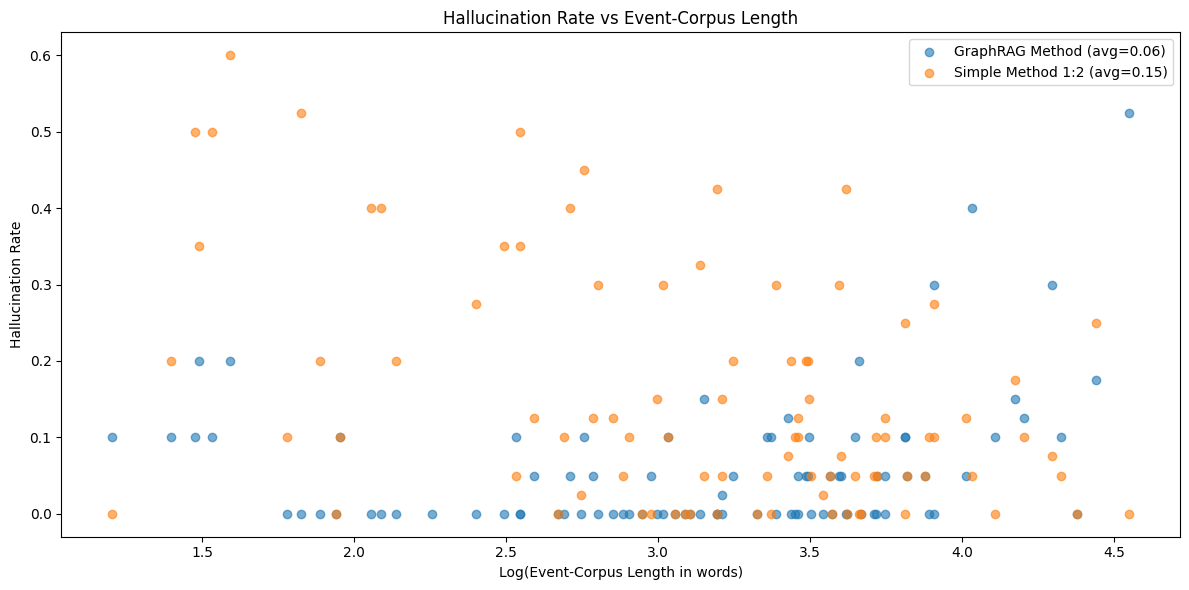

<Figure size 640x480 with 0 Axes>

In [204]:
# Plot the results obtained: hallucination rate vs corpus length for the two methods
import matplotlib.pyplot as plt

# Calculate averages
graph_avg = results_df['graphRAG_hallucination'].apply(lambda x: x['hallucination_rate']).mean()
simple_avg = results_df['simple_hallucination'].apply(lambda x: x['hallucination_rate']).mean()

# Plotting
plt.figure(figsize=(12, 6))

# Scatter plots
plt.scatter(
    np.log10(results_df['corpus_length']),
    results_df['graphRAG_hallucination'].apply(lambda x: x['hallucination_rate']),
    label=f'GraphRAG Method (avg={graph_avg:.2f})',
    alpha=0.6
)
plt.scatter(
    np.log10(results_df['corpus_length']),
    results_df['simple_hallucination'].apply(lambda x: x['hallucination_rate']),
    label=f'Simple Method 1:2 (avg={simple_avg:.2f})',
    alpha=0.6
)

# Average lines
#plt.axhline(graph_avg, color='blue', linestyle='--', linewidth=1)
#plt.axhline(simple_avg, color='orange', linestyle='--', linewidth=1)

# Labels and legend
plt.title('Hallucination Rate vs Event-Corpus Length')
plt.xlabel('Log(Event-Corpus Length in words)')
plt.ylabel('Hallucination Rate')
plt.legend()
plt.tight_layout()

# Show and save
plt.show()
plt.savefig("hallucination_rate_vs_corpus_length_averages.png")



GraphRAG Method: Coefficient = 0.0272, Intercept = -0.0269
Simple Method: Coefficient = -0.0883, Intercept = 0.4297


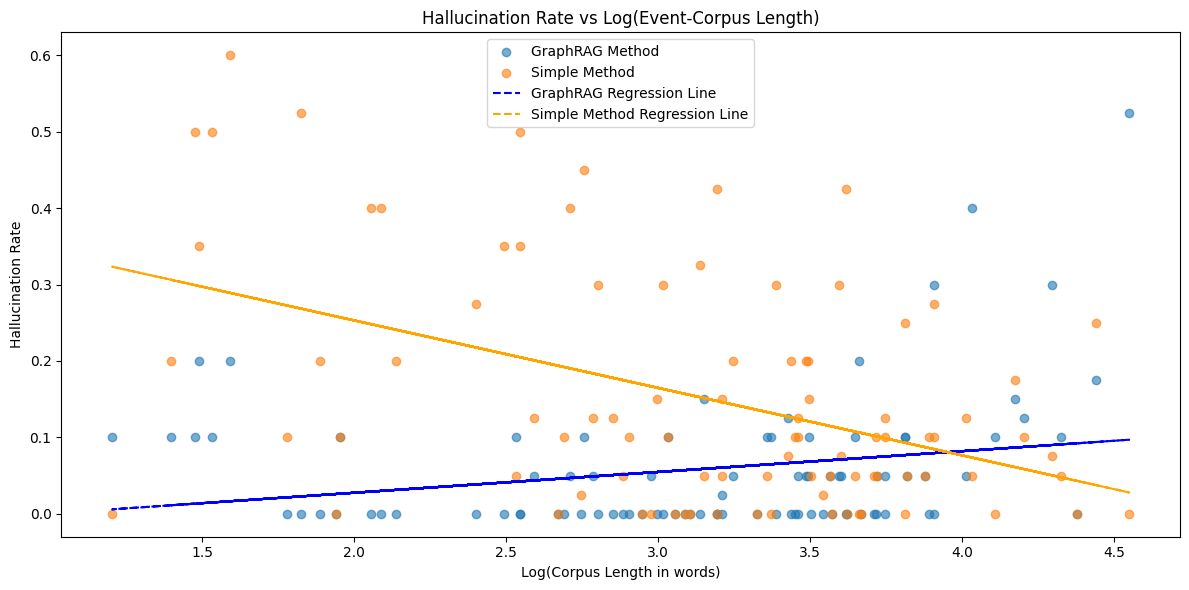

<Figure size 640x480 with 0 Axes>

In [210]:
# check if there's a linear relationship between corpus length and hallucination rate
from sklearn.linear_model import LinearRegression

# Compute log10 of corpus length safely
results_df = results_df.copy()
results_df['log_corpus_length'] = np.log10(results_df['corpus_length'].replace(0, np.nan))

# Extract hallucination rates from nested dicts
results_df['graph_rate'] = results_df['graphRAG_hallucination'].apply(lambda x: x.get('hallucination_rate') if isinstance(x, dict) else np.nan)
results_df['simple_rate'] = results_df['simple_hallucination'].apply(lambda x: x.get('hallucination_rate') if isinstance(x, dict) else np.nan)

# Drop rows with any NaNs in relevant columns
clean_df = results_df.dropna(subset=['log_corpus_length', 'graph_rate', 'simple_rate'])

# Prepare regression inputs
X = clean_df['log_corpus_length'].values.reshape(-1, 1)
y_graph = clean_df['graph_rate'].values
y_simple = clean_df['simple_rate'].values


# Fit linear regression models
graph_model = LinearRegression().fit(X, y_graph)
simple_model = LinearRegression().fit(X, y_simple)
# Get coefficients and intercepts
graph_coef, graph_intercept = graph_model.coef_[0], graph_model.intercept_
simple_coef, simple_intercept = simple_model.coef_[0], simple_model.intercept_
# Print the coefficients and intercepts
print(f"GraphRAG Method: Coefficient = {graph_coef:.4f}, Intercept = {graph_intercept:.4f}")
print(f"Simple Method: Coefficient = {simple_coef:.4f}, Intercept = {simple_intercept:.4f}")

# Plotting
plt.figure(figsize=(12, 6))

# Use cleaned log corpus length and hallucination rates
plt.scatter(
    clean_df['log_corpus_length'],
    clean_df['graph_rate'],
    label='GraphRAG Method',
    alpha=0.6
)

plt.scatter(
    clean_df['log_corpus_length'],
    clean_df['simple_rate'],
    label='Simple Method',
    alpha=0.6
)

# Regression lines
plt.plot(
    clean_df['log_corpus_length'],
    graph_model.predict(X),
    color='blue',
    linestyle='--',
    label='GraphRAG Regression Line'
)
plt.plot(
    clean_df['log_corpus_length'],
    simple_model.predict(X),
    color='orange',
    linestyle='--',
    label='Simple Method Regression Line'
)

# Labels and legend
plt.title('Hallucination Rate vs Log(Event-Corpus Length)')
plt.xlabel('Log(Corpus Length in words)')
plt.ylabel('Hallucination Rate')
plt.legend()
plt.tight_layout()
plt.show()

plt.savefig("hallucination_rate_vs_corpus_length_regression.png")


/var/folders/10/pzn_s4ws6njbfjpsmqzq_dmh0000gn/T/ipykernel_36737/3756780214.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


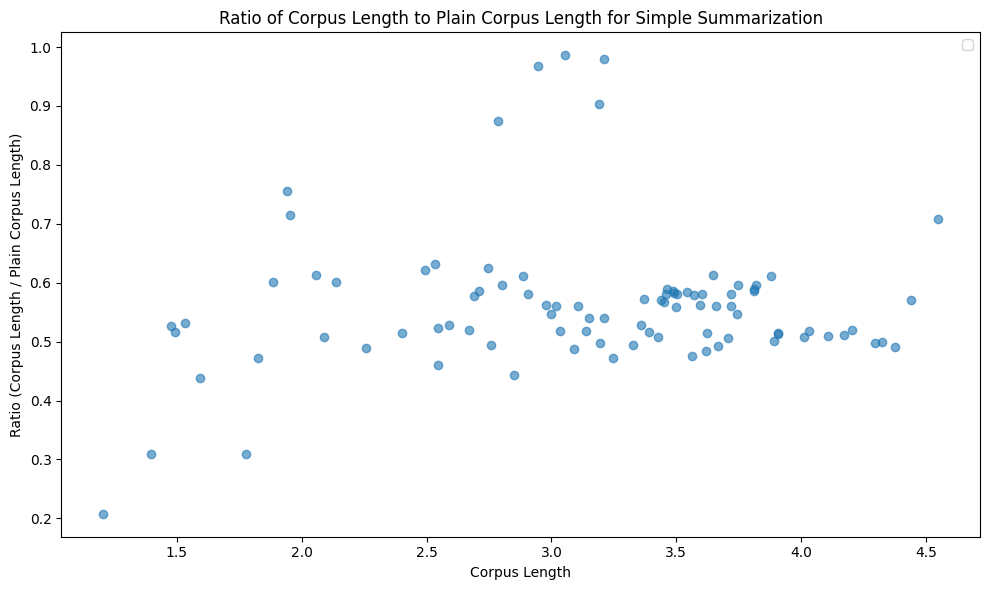

In [214]:
# the negative slope for the simple method can be due to the length truncation for large-corpus summaries
# inspect the summaries sample json to check the ratio between corpus length and plain corpus length

ratios = []
for entry in summaries_sample:
    corpus_length = entry["corpus_length"]
    plain_corpus_length = entry["plain_corpus_length"]
    if plain_corpus_length > 0:  # Avoid division by zero
        ratio = corpus_length / plain_corpus_length
        # append the ratio and the corpus length
        ratios.append((ratio, corpus_length))

# Convert to DataFrame for easier analysis
ratios_df = pd.DataFrame(ratios, columns=['ratio', 'corpus_length'])
# Plot the ratios vs the log of corpus length
plt.figure(figsize=(10, 6))
plt.scatter(np.log10(ratios_df['corpus_length']), ratios_df['ratio'], alpha=0.6)
plt.title('Ratio of Corpus Length to Plain Corpus Length for Simple Summarization')
plt.xlabel('Corpus Length')
plt.ylabel('Ratio (Corpus Length / Plain Corpus Length)')
plt.legend()
plt.tight_layout()
plt.show()

/var/folders/10/pzn_s4ws6njbfjpsmqzq_dmh0000gn/T/ipykernel_36737/5140081.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors_country = plt.cm.get_cmap("tab10", len(results_df['country'].unique()))
/var/folders/10/pzn_s4ws6njbfjpsmqzq_dmh0000gn/T/ipykernel_36737/5140081.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors_type = plt.cm.get_cmap("Set2", len(results_df['event_type'].unique()))


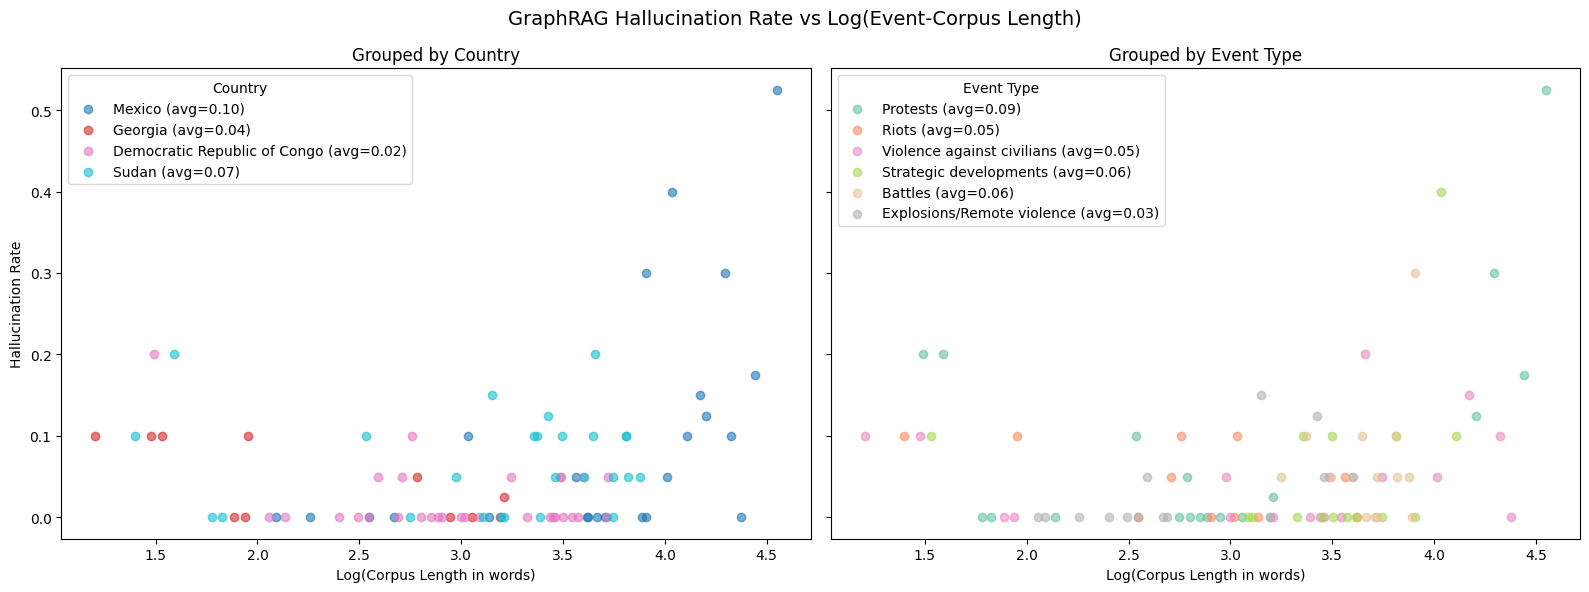

In [197]:
# plot the same results differentiating by country and event type. Only using graphRAG now

# Prepare the figure
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# --- Plot by Country with averages in legend ---
colors_country = plt.cm.get_cmap("tab10", len(results_df['country'].unique()))
for i, country in enumerate(results_df['country'].unique()):
    subset = results_df[results_df['country'] == country]
    rates = subset['graphRAG_hallucination'].apply(lambda x: x['hallucination_rate'])
    avg_rate = rates.mean()
    axes[0].scatter(
        np.log10(subset['corpus_length']),
        rates,
        label=f"{country} (avg={avg_rate:.2f})",
        color=colors_country(i),
        alpha=0.6
    )
axes[0].set_title('Grouped by Country')
axes[0].set_xlabel('Log(Corpus Length in words)')
axes[0].set_ylabel('Hallucination Rate')
axes[0].legend(title='Country')

# --- Plot by Event Type with averages in legend ---
colors_type = plt.cm.get_cmap("Set2", len(results_df['event_type'].unique()))
for j, event_type in enumerate(results_df['event_type'].unique()):
    subset = results_df[results_df['event_type'] == event_type]
    rates = subset['graphRAG_hallucination'].apply(lambda x: x['hallucination_rate'])
    avg_rate = rates.mean()
    axes[1].scatter(
        np.log10(subset['corpus_length']),
        rates,
        label=f"{event_type} (avg={avg_rate:.2f})",
        color=colors_type(j),
        alpha=0.6
    )
axes[1].set_title('Grouped by Event Type')
axes[1].set_xlabel('Log(Corpus Length in words)')
axes[1].legend(title='Event Type')

plt.suptitle('GraphRAG Hallucination Rate vs Log(Event-Corpus Length)', fontsize=14)
plt.tight_layout()
#plt.savefig("hallucination_rate_vs_corpus_length_grouped.png")
plt.show()


#### - GraphRAG yields less hallucination, therefore justifying the knowledge graph
#### - Size affects hallucination rate for graphRAG but mildly; however all top rates happen from 700 events approx, therefore justifying our "modular" approach
#### - No evident differences across countries nor event types (only due to size); method seems generalizable

## 4.2. 2/3 Format Test; vs size, vs method

In [215]:
# format evaluation

with open("summaries_sample_big.json", "r") as f:
    summaries_sample = json.load(f)

# Evaluate each summary in the sample
results_format = []
for entry in summaries_sample:
    country = entry["country"]
    month = entry["month"]
    event_type = entry["event_type"]
    corpus = entry["corpus"]
    graphRAG_summary = entry["graphRAG_summary"]
    simple_summary = entry["simple_summary"]
    plain_corpus_length = entry["plain_corpus_length"]
    corpus_length = entry["corpus_length"]

    # Evaluate format
    graph_format_eval = evaluate_format(graphRAG_summary, length=500, iterations=5)
    simple_format_eval = evaluate_format(simple_summary, length=500, iterations=5)

    

    results_format.append({
        "country": country,
        "month": month,
        "event_type": event_type,
        "corpus_length": corpus_length,
        "graphRAG_format": graph_format_eval,
        "simple_format": simple_format_eval,
        #"graphRAG_hallucination": graph_hallucination_eval,
        #"simple_hallucination": simple_hallucination_eval
    })

# Save the evaluation results to an csv file
results_format_df = pd.DataFrame(results_format)
results_format_df.to_csv("format_results_big.csv", index=False)

Evaluating format: 100%|██████████| 5/5 [00:00<00:00,  8.04it/s]


Format deviation rate: 1.0


Evaluating format: 100%|██████████| 5/5 [00:00<00:00, 16.25it/s]


Format deviation rate: 1.0


Evaluating format: 100%|██████████| 5/5 [00:01<00:00,  4.95it/s]


Format deviation rate: 1.0


Evaluating format: 100%|██████████| 5/5 [00:00<00:00, 19.18it/s]


Format deviation rate: 1.0


Evaluating format: 100%|██████████| 5/5 [00:00<00:00,  6.74it/s]


Format deviation rate: 1.0


Evaluating format: 100%|██████████| 5/5 [00:00<00:00, 20.06it/s]


Format deviation rate: 1.0


Evaluating format: 100%|██████████| 5/5 [00:00<00:00, 18.51it/s]


Format deviation rate: 1.0


Evaluating format: 100%|██████████| 5/5 [00:00<00:00,  6.49it/s]


Format deviation rate: 1.0


Evaluating format: 100%|██████████| 5/5 [00:00<00:00, 12.98it/s]


Format deviation rate: 1.0


Evaluating format: 100%|██████████| 5/5 [00:00<00:00, 18.73it/s]


Format deviation rate: 1.0


Evaluating format: 100%|██████████| 5/5 [00:00<00:00, 19.01it/s]


Format deviation rate: 1.0


Evaluating format: 100%|██████████| 5/5 [00:00<00:00, 13.00it/s]


Format deviation rate: 1.0


Evaluating format: 100%|██████████| 5/5 [00:59<00:00, 11.83s/it]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


Format deviation rate: 0.8


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Format deviation rate: 0.15999999999999992


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Format deviation rate: 0.4


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Format deviation rate: 0.96


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


Format deviation rate: 0.5599999999999999


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


Format deviation rate: 0.6


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.00it/s]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


Format deviation rate: 0.6799999999999999


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


Format deviation rate: 0.0


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Format deviation rate: 0.4


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


Format deviation rate: 0.6


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Format deviation rate: 1.0


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


Format deviation rate: 0.4


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


Format deviation rate: 0.28


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


Format deviation rate: 0.8


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


Format deviation rate: 0.4


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Format deviation rate: 0.15999999999999992


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Format deviation rate: 0.5599999999999999


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


Format deviation rate: 0.8


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


Format deviation rate: 0.4


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Format deviation rate: 0.4


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.03s/it]


Format deviation rate: 0.4


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.03s/it]


Format deviation rate: 0.0


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Format deviation rate: 0.28


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


Format deviation rate: 0.4


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Format deviation rate: 0.4


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Format deviation rate: 0.36


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Format deviation rate: 1.0


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.06s/it]


Format deviation rate: 0.4


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Format deviation rate: 0.4


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


Format deviation rate: 0.28


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Format deviation rate: 1.0


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


Format deviation rate: 1.0


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


Format deviation rate: 0.0


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


Format deviation rate: 1.0


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.00it/s]


Format deviation rate: 0.15999999999999992


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Format deviation rate: 1.0


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


Format deviation rate: 0.4


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


Format deviation rate: 1.0


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Format deviation rate: 0.4


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.06s/it]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


Format deviation rate: 1.0


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.06s/it]


Format deviation rate: 0.5599999999999999


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


Format deviation rate: 1.0


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


Format deviation rate: 0.4


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Format deviation rate: 0.28


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Format deviation rate: 0.4


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


Format deviation rate: 1.0


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Format deviation rate: 0.24


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.03s/it]


Format deviation rate: 1.0


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Format deviation rate: 0.4


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Format deviation rate: 1.0


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Format deviation rate: 0.52


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Format deviation rate: 1.0


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Format deviation rate: 0.0


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Format deviation rate: 0.4


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Format deviation rate: 1.0


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Format deviation rate: 1.0


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Format deviation rate: 0.6


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Format deviation rate: 1.0


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


Format deviation rate: 0.4


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Format deviation rate: 1.0


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Format deviation rate: 0.4


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Format deviation rate: 1.0


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


Format deviation rate: 1.0


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


Format deviation rate: 0.6


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.03s/it]


Format deviation rate: 1.0


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Format deviation rate: 0.44000000000000006


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


Format deviation rate: 0.11999999999999988


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Format deviation rate: 0.4


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


Format deviation rate: 0.64


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Format deviation rate: 0.4


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Format deviation rate: 0.0


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:00<00:00, 15.82it/s]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Format deviation rate: 0.15999999999999992


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


Format deviation rate: 0.6


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Format deviation rate: 0.4


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


Format deviation rate: 0.4


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Format deviation rate: 0.040000000000000036


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Format deviation rate: 0.4


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Format deviation rate: 0.44000000000000006


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


Format deviation rate: 0.6


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.17s/it]


Format deviation rate: 0.8


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Format deviation rate: 0.32000000000000006


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


Format deviation rate: 0.4


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


Format deviation rate: 0.8


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Format deviation rate: 0.4


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


Format deviation rate: 0.0


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Format deviation rate: 0.4


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.00it/s]


Format deviation rate: 0.5599999999999999


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Format deviation rate: 0.040000000000000036


Evaluating format: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:06<00:00,  1.33s/it]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


Format deviation rate: 1.0


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:06<00:00,  1.23s/it]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.06s/it]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


Format deviation rate: 0.5599999999999999


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Format deviation rate: 0.6


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.06s/it]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Format deviation rate: 0.6


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


Format deviation rate: 0.4


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Format deviation rate: 1.0


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


Format deviation rate: 0.4


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Format deviation rate: 0.4


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.03s/it]


Format deviation rate: 0.36


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.00it/s]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Format deviation rate: 0.6799999999999999


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Format deviation rate: 0.4


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.03s/it]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Format deviation rate: 0.4


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.03s/it]


Format deviation rate: 0.6


Evaluating format: 100%|██████████| 5/5 [00:11<00:00,  2.31s/it]


Format deviation rate: 0.6


Evaluating format: 100%|██████████| 5/5 [00:00<00:00, 17.65it/s]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Format deviation rate: 1.0


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Format deviation rate: 0.0


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


Format deviation rate: 0.0


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Format deviation rate: 0.4


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Format deviation rate: 0.8


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Format deviation rate: 0.6


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.03s/it]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


Format deviation rate: 0.6


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Format deviation rate: 0.4


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


Format deviation rate: 0.4


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


Format deviation rate: 0.4


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.00it/s]


Format deviation rate: 0.6


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


Format deviation rate: 0.4


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


Format deviation rate: 0.44000000000000006


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Format deviation rate: 1.0


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Format deviation rate: 0.0


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.16s/it]


Format deviation rate: 0.4


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


Format deviation rate: 0.4


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Format deviation rate: 0.4


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Format deviation rate: 0.4


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Format deviation rate: 0.4


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


Format deviation rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


Format deviation rate: 0.5599999999999999


## Format Test RESULTS

/Users/ferranboadabergada/opt/anaconda3/envs/thesis_copy/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


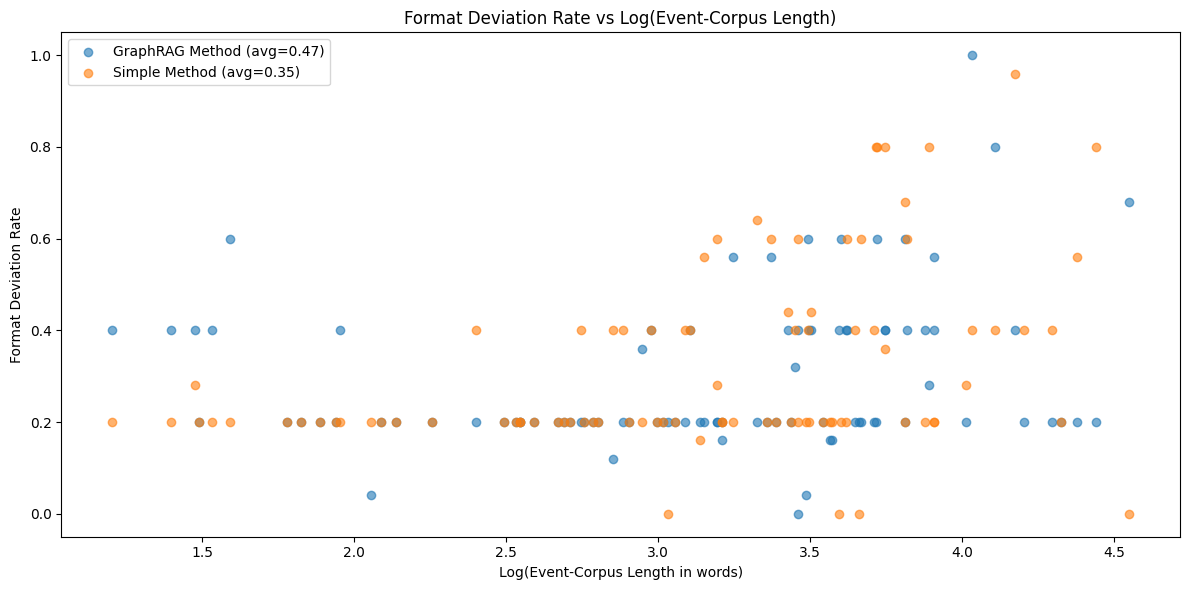

<Figure size 640x480 with 0 Axes>

In [218]:
import ast

# Load results
results_format_df = pd.read_csv("format_results_big.csv")

# Parse stringified dicts if needed
def extract_deviation(val):
    if isinstance(val, str):
        val = ast.literal_eval(val)
    return val.get("Format deviation rate", None)

# Extract deviations
results_format_df["graphRAG_deviation"] = results_format_df["graphRAG_format"].apply(extract_deviation)
results_format_df["simple_deviation"] = results_format_df["simple_format"].apply(extract_deviation)

# Drop any invalid rows
results_format_df.dropna(subset=["graphRAG_deviation", "simple_deviation", "corpus_length"], inplace=True)

# Calculate averages
graph_avg = results_format_df["graphRAG_deviation"].mean()
simple_avg = results_format_df["simple_deviation"].mean()

# Plot
plt.figure(figsize=(12, 6))

plt.scatter(
    np.log10(results_format_df["corpus_length"]),
    results_format_df["graphRAG_deviation"],
    label=f'GraphRAG Method (avg={graph_avg:.2f})',
    alpha=0.6
)
plt.scatter(
    np.log10(results_format_df["corpus_length"]),
    results_format_df["simple_deviation"],
    label=f'Simple Method (avg={simple_avg:.2f})',
    alpha=0.6
)

# Labels and legend
plt.title("Format Deviation Rate vs Log(Event-Corpus Length)")
plt.xlabel("Log(Event-Corpus Length in words)")
plt.ylabel("Format Deviation Rate")
plt.legend()
plt.tight_layout()

plt.show()
plt.savefig("format_deviation_vs_corpus_length.png")

In [219]:
# prompt iteration vs temperature

import random
import json
from tqdm import tqdm

# Load the full data
with open("summaries_sample_big.json", "r") as f:
    full_data = json.load(f)

# Step 1: Select n random corpus samples
n = 10  # Number of corpus samples
random.seed(42)
selected_samples = random.sample(full_data, n)

# Step 2: Define the temperatures to test
temperatures = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9 , 1.0]

# Step 3: Run the experiment
results_temp = []

for sample in tqdm(selected_samples, desc="Generating summaries with temperature variations"):
    for temp in temperatures:
        print("Temperature:", temp)
        try:
            # Generate the summary
            summary, _ = summarize_events(
                uri=BOLT_URI,
                user=USER,
                pwd=PWD,
                country=sample["country"],
                month=sample["month"],
                year=2025,
                event_type=sample["event_type"],
                context="",  # Keep context fixed
                temperature=temp
            )

            # Evaluate hallucination and format
            hallucination_eval = evaluate_hallucination(
                summary=summary,
                test_corpus=sample["corpus"],
                manual=True,
                iterations=2,
                num_questions=20  
            )

            format_eval = evaluate_format(
                summary=summary,
                length=500,
                iterations=5
            )

            # Record result
            results_temp.append({
                "country": sample["country"],
                "month": sample["month"],
                "event_type": sample["event_type"],
                "temperature": temp,
                "summary": summary,
                "hallucination": hallucination_eval,
                "format": format_eval
            })

        except Exception as e:
            print(f"⚠️ Failed at {sample['country']} {sample['month']} {sample['event_type']} (temp={temp}): {e}")
            continue

# save to a csv file
results_temp_df = pd.DataFrame(results_temp)
results_temp_df.to_csv("temperature_experiment_results.csv", index=False)

Generating summaries with temperature variations:   0%|          | 0/10 [00:00<?, ?it/s]

Temperature: 0.1
total events found: 74


Evaluating: 100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 5/5 [00:00<00:00, 13.92it/s]


Format deviation rate: 0.19999999999999996
Temperature: 0.2
total events found: 74


Evaluating: 100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 5/5 [00:00<00:00, 12.68it/s]


Format deviation rate: 0.19999999999999996
Temperature: 0.3
total events found: 74
Error found. Retrying to generate questions at step 1.
Error found. Retrying to generate questions at step 1.


Evaluating: 100%|██████████| 4/4 [00:08<00:00,  2.08s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 5/5 [00:00<00:00,  6.07it/s]


Format deviation rate: 0.36
Temperature: 0.4
total events found: 74
Error found. Retrying to generate questions at step 1.


Evaluating: 100%|██████████| 4/4 [00:14<00:00,  3.50s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 5/5 [00:00<00:00, 18.38it/s]


Format deviation rate: 0.4
Temperature: 0.5
total events found: 74


Evaluating: 100%|██████████| 4/4 [00:11<00:00,  2.81s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 5/5 [00:00<00:00, 11.26it/s]


Format deviation rate: 0.19999999999999996
Temperature: 0.6
total events found: 74


Evaluating: 100%|██████████| 4/4 [00:11<00:00,  2.94s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 5/5 [00:00<00:00, 16.60it/s]


Format deviation rate: 0.19999999999999996
Temperature: 0.7
total events found: 74


Evaluating: 100%|██████████| 4/4 [00:12<00:00,  3.06s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 5/5 [00:00<00:00, 15.12it/s]


Format deviation rate: 0.4
Temperature: 0.8
total events found: 74


Evaluating: 100%|██████████| 4/4 [00:11<00:00,  2.89s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 5/5 [00:00<00:00, 12.36it/s]


Format deviation rate: 0.4
Temperature: 0.9
total events found: 74


Evaluating: 100%|██████████| 4/4 [00:10<00:00,  2.74s/it]


Hallucination rate: 0.025000000000000022


Evaluating format: 100%|██████████| 5/5 [00:00<00:00, 13.89it/s]


Format deviation rate: 0.6
Temperature: 1.0
total events found: 74
Error found. Retrying to generate questions at step 1.


Evaluating: 100%|██████████| 4/4 [00:12<00:00,  3.10s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 5/5 [00:00<00:00, 10.17it/s]
Generating summaries with temperature variations:  10%|█         | 1/10 [06:28<58:20, 388.98s/it]

Format deviation rate: 0.19999999999999996
Temperature: 0.1
total events found: 476


Evaluating: 100%|██████████| 4/4 [00:08<00:00,  2.12s/it]


Hallucination rate: 0.09999999999999998


Evaluating format: 100%|██████████| 5/5 [00:00<00:00, 18.48it/s]


Format deviation rate: 0.19999999999999996
Temperature: 0.2
total events found: 476


Evaluating: 100%|██████████| 4/4 [00:27<00:00,  6.88s/it]


Hallucination rate: 0.050000000000000044


Evaluating format: 100%|██████████| 5/5 [00:00<00:00, 14.37it/s]


Format deviation rate: 0.19999999999999996
Temperature: 0.3
total events found: 476


Evaluating: 100%|██████████| 4/4 [00:08<00:00,  2.20s/it]


Hallucination rate: 0.050000000000000044


Evaluating format: 100%|██████████| 5/5 [00:00<00:00, 15.39it/s]


Format deviation rate: 0.19999999999999996
Temperature: 0.4
total events found: 476


Evaluating: 100%|██████████| 4/4 [00:11<00:00,  2.87s/it]


Hallucination rate: 0.19999999999999996


Evaluating format: 100%|██████████| 5/5 [00:00<00:00, 15.01it/s]


Format deviation rate: 0.19999999999999996
Temperature: 0.5
total events found: 476


Evaluating: 100%|██████████| 4/4 [00:08<00:00,  2.12s/it]


Hallucination rate: 0.25


Evaluating format: 100%|██████████| 5/5 [00:00<00:00, 14.80it/s]


Format deviation rate: 0.19999999999999996
Temperature: 0.6
total events found: 476


Evaluating: 100%|██████████| 4/4 [00:09<00:00,  2.35s/it]


Hallucination rate: 0.09999999999999998


Evaluating format: 100%|██████████| 5/5 [00:00<00:00, 12.87it/s]


Format deviation rate: 0.19999999999999996
Temperature: 0.7
total events found: 476


Evaluating: 100%|██████████| 4/4 [00:08<00:00,  2.23s/it]


Hallucination rate: 0.050000000000000044


Evaluating format: 100%|██████████| 5/5 [00:00<00:00, 16.09it/s]


Format deviation rate: 0.36
Temperature: 0.8
total events found: 476


Evaluating: 100%|██████████| 4/4 [00:11<00:00,  2.76s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 5/5 [00:00<00:00, 16.99it/s]


Format deviation rate: 0.19999999999999996
Temperature: 0.9
total events found: 476


Evaluating: 100%|██████████| 4/4 [00:14<00:00,  3.58s/it]


Hallucination rate: 0.09999999999999998


Evaluating format: 100%|██████████| 5/5 [00:00<00:00,  9.98it/s]


Format deviation rate: 0.4
Temperature: 1.0
total events found: 476


Evaluating: 100%|██████████| 4/4 [00:16<00:00,  4.19s/it]


Hallucination rate: 0.09999999999999998


Evaluating format: 100%|██████████| 5/5 [00:00<00:00, 12.24it/s]
Generating summaries with temperature variations:  20%|██        | 2/10 [12:24<49:13, 369.15s/it]

Format deviation rate: 0.4
Temperature: 0.1
total events found: 0


Evaluating: 0it [00:00, ?it/s]


Hallucination rate: None


Evaluating format: 100%|██████████| 5/5 [00:00<00:00, 16.47it/s]


Format deviation rate: 1.0
Temperature: 0.2
total events found: 0


Evaluating: 0it [00:00, ?it/s]


Hallucination rate: None


Evaluating format: 100%|██████████| 5/5 [00:00<00:00, 17.81it/s]


Format deviation rate: 1.0
Temperature: 0.3
total events found: 0


Evaluating: 0it [00:00, ?it/s]


Hallucination rate: None


Evaluating format: 100%|██████████| 5/5 [00:00<00:00, 14.80it/s]


Format deviation rate: 1.0
Temperature: 0.4
total events found: 0


Evaluating: 0it [00:00, ?it/s]


Hallucination rate: None


Evaluating format: 100%|██████████| 5/5 [00:00<00:00, 16.23it/s]


Format deviation rate: 1.0
Temperature: 0.5
total events found: 0


Evaluating: 0it [00:00, ?it/s]


Hallucination rate: None


Evaluating format: 100%|██████████| 5/5 [00:00<00:00,  9.32it/s]


Format deviation rate: 1.0
Temperature: 0.6
total events found: 0


Evaluating: 0it [00:00, ?it/s]


Hallucination rate: None


Evaluating format: 100%|██████████| 5/5 [00:00<00:00,  9.28it/s]


Format deviation rate: 1.0
Temperature: 0.7
total events found: 0


Evaluating: 0it [00:00, ?it/s]


Hallucination rate: None


Evaluating format: 100%|██████████| 5/5 [00:00<00:00,  6.29it/s]


Format deviation rate: 1.0
Temperature: 0.8
total events found: 0


Evaluating: 0it [00:00, ?it/s]


Hallucination rate: None


Evaluating format: 100%|██████████| 5/5 [00:00<00:00, 19.63it/s]


Format deviation rate: 1.0
Temperature: 0.9
total events found: 0


Evaluating: 0it [00:00, ?it/s]


Hallucination rate: None


Evaluating format: 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Format deviation rate: 1.0
Temperature: 1.0
total events found: 0


Evaluating: 0it [00:00, ?it/s]


Hallucination rate: None


Evaluating format: 100%|██████████| 5/5 [00:21<00:00,  4.32s/it]
Generating summaries with temperature variations:  30%|███       | 3/10 [12:52<24:53, 213.39s/it]

Format deviation rate: 1.0
Temperature: 0.1
total events found: 42
⚠️ Failed at Sudan 1 Battles (temp=0.1): API request failed: 429 - {"object":"error","message":"Rate limit exceeded","type":"rate_limited","param":null,"code":"1300"}
Temperature: 0.2
total events found: 42
⚠️ Failed at Sudan 1 Battles (temp=0.2): API request failed: 429 - {"object":"error","message":"Rate limit exceeded","type":"rate_limited","param":null,"code":"1300"}
Temperature: 0.3
total events found: 42
⚠️ Failed at Sudan 1 Battles (temp=0.3): API request failed: 429 - {"object":"error","message":"Rate limit exceeded","type":"rate_limited","param":null,"code":"1300"}
Temperature: 0.4
total events found: 42
⚠️ Failed at Sudan 1 Battles (temp=0.4): API request failed: 429 - {"object":"error","message":"Rate limit exceeded","type":"rate_limited","param":null,"code":"1300"}
Temperature: 0.5
total events found: 42
⚠️ Failed at Sudan 1 Battles (temp=0.5): API request failed: 429 - {"object":"error","message":"Rate limi

Generating summaries with temperature variations:  40%|████      | 4/10 [12:54<12:59, 129.91s/it]

⚠️ Failed at Sudan 1 Battles (temp=1.0): API request failed: 429 - {"object":"error","message":"Rate limit exceeded","type":"rate_limited","param":null,"code":"1300"}
Temperature: 0.1
total events found: 0


Evaluating: 0it [00:00, ?it/s]


Hallucination rate: None


Evaluating format: 100%|██████████| 5/5 [00:09<00:00,  1.92s/it]


Format deviation rate: 1.0
Temperature: 0.2
total events found: 0


Evaluating: 0it [00:00, ?it/s]


Hallucination rate: None


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Format deviation rate: 1.0
Temperature: 0.3
total events found: 0


Evaluating: 0it [00:00, ?it/s]


Hallucination rate: None


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


Format deviation rate: 1.0
Temperature: 0.4
total events found: 0


Evaluating: 0it [00:00, ?it/s]


Hallucination rate: None


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Format deviation rate: 1.0
Temperature: 0.5
total events found: 0


Evaluating: 0it [00:00, ?it/s]


Hallucination rate: None


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


Format deviation rate: 1.0
Temperature: 0.6
total events found: 0


Evaluating: 0it [00:00, ?it/s]


Hallucination rate: None


Evaluating format: 100%|██████████| 5/5 [00:07<00:00,  1.59s/it]


Format deviation rate: 1.0
Temperature: 0.7
total events found: 0


Evaluating: 0it [00:00, ?it/s]


Hallucination rate: None


Evaluating format: 100%|██████████| 5/5 [00:02<00:00,  2.48it/s]


Format deviation rate: 1.0
Temperature: 0.8
total events found: 0


Evaluating: 0it [00:00, ?it/s]


Hallucination rate: None


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.00it/s]


Format deviation rate: 1.0
Temperature: 0.9
total events found: 0


Evaluating: 0it [00:00, ?it/s]


Hallucination rate: None


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Format deviation rate: 1.0
Temperature: 1.0
total events found: 0


Evaluating: 0it [00:00, ?it/s]


Hallucination rate: None


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.00it/s]
Generating summaries with temperature variations:  50%|█████     | 5/10 [13:48<08:33, 102.75s/it]

Format deviation rate: 1.0
Temperature: 0.1
total events found: 0


Evaluating: 0it [00:00, ?it/s]


Hallucination rate: None


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Format deviation rate: 1.0
Temperature: 0.2
total events found: 0


Evaluating: 0it [00:00, ?it/s]


Hallucination rate: None


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Format deviation rate: 1.0
Temperature: 0.3
total events found: 0


Evaluating: 0it [00:00, ?it/s]


Hallucination rate: None


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Format deviation rate: 1.0
Temperature: 0.4
total events found: 0


Evaluating: 0it [00:00, ?it/s]


Hallucination rate: None


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.03s/it]


Format deviation rate: 1.0
Temperature: 0.5
total events found: 0


Evaluating: 0it [00:00, ?it/s]


Hallucination rate: None


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


Format deviation rate: 1.0
Temperature: 0.6
total events found: 0


Evaluating: 0it [00:00, ?it/s]


Hallucination rate: None


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


Format deviation rate: 1.0
Temperature: 0.7
total events found: 0


Evaluating: 0it [00:00, ?it/s]


Hallucination rate: None


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


Format deviation rate: 1.0
Temperature: 0.8
total events found: 0


Evaluating: 0it [00:00, ?it/s]


Hallucination rate: None


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Format deviation rate: 1.0
Temperature: 0.9
total events found: 0


Evaluating: 0it [00:00, ?it/s]


Hallucination rate: None


Evaluating format: 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Format deviation rate: 1.0
Temperature: 1.0
total events found: 0


Evaluating: 0it [00:00, ?it/s]


Hallucination rate: None


Evaluating format: 100%|██████████| 5/5 [00:05<00:00,  1.03s/it]
Generating summaries with temperature variations:  60%|██████    | 6/10 [14:38<05:39, 84.84s/it] 

Format deviation rate: 1.0
Temperature: 0.1
total events found: 98
⚠️ Failed at Mexico 5 Battles (temp=0.1): API request failed: 429 - {"object":"error","message":"Rate limit exceeded","type":"rate_limited","param":null,"code":"1300"}
Temperature: 0.2
total events found: 98
⚠️ Failed at Mexico 5 Battles (temp=0.2): API request failed: 429 - {"object":"error","message":"Rate limit exceeded","type":"rate_limited","param":null,"code":"1300"}
Temperature: 0.3
total events found: 98
⚠️ Failed at Mexico 5 Battles (temp=0.3): API request failed: 429 - {"object":"error","message":"Rate limit exceeded","type":"rate_limited","param":null,"code":"1300"}
Temperature: 0.4
total events found: 98


Evaluating: 100%|██████████| 4/4 [00:12<00:00,  3.10s/it]


Hallucination rate: 0.050000000000000044


Evaluating format: 100%|██████████| 5/5 [00:00<00:00,  9.46it/s]


Format deviation rate: 0.36
Temperature: 0.5
total events found: 98


Evaluating: 100%|██████████| 4/4 [00:07<00:00,  1.97s/it]


Hallucination rate: 0.15000000000000002


Evaluating format: 100%|██████████| 5/5 [00:00<00:00, 18.16it/s]


Format deviation rate: 0.4
Temperature: 0.6
total events found: 98


Evaluating: 100%|██████████| 4/4 [00:06<00:00,  1.74s/it]


Hallucination rate: 0.07499999999999996


Evaluating format: 100%|██████████| 5/5 [00:00<00:00,  7.54it/s]


Format deviation rate: 0.24
Temperature: 0.7
total events found: 98


Evaluating: 100%|██████████| 4/4 [00:14<00:00,  3.61s/it]


Hallucination rate: 0.09999999999999998


Evaluating format: 100%|██████████| 5/5 [00:00<00:00, 18.08it/s]


Format deviation rate: 0.040000000000000036
Temperature: 0.8
total events found: 98


Evaluating: 100%|██████████| 4/4 [00:08<00:00,  2.11s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 5/5 [00:00<00:00, 17.27it/s]


Format deviation rate: 0.19999999999999996
Temperature: 0.9
total events found: 98


Evaluating: 100%|██████████| 4/4 [00:08<00:00,  2.25s/it]


Hallucination rate: 0.125


Evaluating format: 100%|██████████| 5/5 [00:00<00:00, 14.25it/s]


Format deviation rate: 0.4
Temperature: 1.0
total events found: 98


Evaluating: 100%|██████████| 4/4 [00:09<00:00,  2.28s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 5/5 [00:00<00:00, 15.03it/s]
Generating summaries with temperature variations:  70%|███████   | 7/10 [19:15<07:22, 147.37s/it]

Format deviation rate: 0.19999999999999996
Temperature: 0.1
total events found: 3


Evaluating: 100%|██████████| 4/4 [00:06<00:00,  1.74s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


Format deviation rate: 0.19999999999999996
Temperature: 0.2
total events found: 3


Evaluating: 100%|██████████| 4/4 [00:08<00:00,  2.20s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 5/5 [00:00<00:00, 15.35it/s]


Format deviation rate: 0.19999999999999996
Temperature: 0.3
total events found: 3


Evaluating: 100%|██████████| 4/4 [00:07<00:00,  1.92s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 5/5 [00:00<00:00, 13.22it/s]


Format deviation rate: 0.19999999999999996
Temperature: 0.4
total events found: 3


Evaluating: 100%|██████████| 4/4 [00:11<00:00,  2.94s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 5/5 [00:00<00:00, 11.81it/s]


Format deviation rate: 0.19999999999999996
Temperature: 0.5
total events found: 3


Evaluating: 100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 5/5 [00:00<00:00,  8.23it/s]


Format deviation rate: 0.19999999999999996
Temperature: 0.6
total events found: 3


Evaluating: 100%|██████████| 4/4 [00:09<00:00,  2.35s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 5/5 [00:00<00:00, 13.49it/s]


Format deviation rate: 0.19999999999999996
Temperature: 0.7
total events found: 3


Evaluating: 100%|██████████| 4/4 [00:22<00:00,  5.68s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 5/5 [00:00<00:00, 12.58it/s]


Format deviation rate: 0.0
Temperature: 0.8
total events found: 3


Evaluating: 100%|██████████| 4/4 [00:15<00:00,  3.94s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 5/5 [00:00<00:00, 13.22it/s]


Format deviation rate: 0.19999999999999996
Temperature: 0.9
total events found: 3


Evaluating: 100%|██████████| 4/4 [00:05<00:00,  1.48s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 5/5 [00:00<00:00, 17.01it/s]


Format deviation rate: 0.19999999999999996
Temperature: 1.0
total events found: 3


Evaluating: 100%|██████████| 4/4 [00:07<00:00,  1.78s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 5/5 [00:00<00:00, 10.81it/s]
Generating summaries with temperature variations:  80%|████████  | 8/10 [24:35<06:45, 202.62s/it]

Format deviation rate: 0.19999999999999996
Temperature: 0.1
total events found: 67


Evaluating: 100%|██████████| 4/4 [00:20<00:00,  5.06s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 5/5 [00:00<00:00, 11.92it/s]


Format deviation rate: 0.6
Temperature: 0.2
total events found: 67


Evaluating: 100%|██████████| 4/4 [00:08<00:00,  2.17s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 5/5 [00:00<00:00, 14.10it/s]


Format deviation rate: 0.4
Temperature: 0.3
total events found: 67


Evaluating: 100%|██████████| 4/4 [00:13<00:00,  3.34s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 5/5 [00:00<00:00, 13.32it/s]


Format deviation rate: 0.52
Temperature: 0.4
total events found: 67


Evaluating: 100%|██████████| 4/4 [00:09<00:00,  2.35s/it]


Hallucination rate: 0.025000000000000022


Evaluating format: 100%|██████████| 5/5 [00:00<00:00, 12.43it/s]


Format deviation rate: 0.19999999999999996
Temperature: 0.5
total events found: 67


Evaluating: 100%|██████████| 4/4 [00:10<00:00,  2.66s/it]


Hallucination rate: 0.050000000000000044


Evaluating format: 100%|██████████| 5/5 [00:00<00:00, 15.70it/s]


Format deviation rate: 0.6
Temperature: 0.6
total events found: 67


Evaluating: 100%|██████████| 4/4 [00:08<00:00,  2.07s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 5/5 [00:00<00:00, 12.93it/s]


Format deviation rate: 0.6
Temperature: 0.7
total events found: 67


Evaluating: 100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


Format deviation rate: 0.0
Temperature: 0.8
total events found: 67


Evaluating: 100%|██████████| 4/4 [00:09<00:00,  2.41s/it]


Hallucination rate: 0.09999999999999998


Evaluating format: 100%|██████████| 5/5 [00:00<00:00, 17.82it/s]


Format deviation rate: 0.19999999999999996
Temperature: 0.9
total events found: 67


Evaluating: 100%|██████████| 4/4 [00:13<00:00,  3.48s/it]


Hallucination rate: 0.025000000000000022


Evaluating format: 100%|██████████| 5/5 [00:00<00:00, 13.59it/s]


Format deviation rate: 0.4
Temperature: 1.0
total events found: 67


Evaluating: 100%|██████████| 4/4 [00:15<00:00,  3.92s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 5/5 [00:00<00:00, 16.26it/s]
Generating summaries with temperature variations:  90%|█████████ | 9/10 [31:08<04:22, 262.04s/it]

Format deviation rate: 0.6
Temperature: 0.1
total events found: 43


Evaluating: 100%|██████████| 4/4 [00:11<00:00,  2.78s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 5/5 [00:00<00:00,  7.17it/s]


Format deviation rate: 0.0
Temperature: 0.2
total events found: 43


Evaluating: 100%|██████████| 4/4 [00:15<00:00,  3.91s/it]


Hallucination rate: 0.15000000000000002


Evaluating format: 100%|██████████| 5/5 [00:00<00:00, 11.00it/s]


Format deviation rate: 0.19999999999999996
Temperature: 0.3
total events found: 43


Evaluating: 100%|██████████| 4/4 [00:11<00:00,  2.87s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 5/5 [00:00<00:00, 13.56it/s]


Format deviation rate: 0.19999999999999996
Temperature: 0.4
total events found: 43


Evaluating: 100%|██████████| 4/4 [00:09<00:00,  2.43s/it]


Hallucination rate: 0.050000000000000044


Evaluating format: 100%|██████████| 5/5 [00:00<00:00,  6.14it/s]


Format deviation rate: 0.19999999999999996
Temperature: 0.5
total events found: 43


Evaluating: 100%|██████████| 4/4 [00:11<00:00,  2.86s/it]


Hallucination rate: 0.050000000000000044


Evaluating format: 100%|██████████| 5/5 [00:01<00:00,  4.46it/s]


Format deviation rate: 0.19999999999999996
Temperature: 0.6
total events found: 43


Evaluating: 100%|██████████| 4/4 [00:08<00:00,  2.17s/it]


Hallucination rate: 0.050000000000000044


Evaluating format: 100%|██████████| 5/5 [00:01<00:00,  4.90it/s]


Format deviation rate: 0.19999999999999996
Temperature: 0.7
total events found: 43


Evaluating: 100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


Hallucination rate: 0.050000000000000044


Evaluating format: 100%|██████████| 5/5 [00:01<00:00,  2.83it/s]


Format deviation rate: 0.19999999999999996
Temperature: 0.8
total events found: 43


Evaluating: 100%|██████████| 4/4 [00:09<00:00,  2.28s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 5/5 [00:00<00:00, 17.53it/s]


Format deviation rate: 0.19999999999999996
Temperature: 0.9
total events found: 43


Evaluating: 100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 5/5 [00:00<00:00, 13.71it/s]


Format deviation rate: 0.0
Temperature: 1.0
total events found: 43


Evaluating: 100%|██████████| 4/4 [00:13<00:00,  3.36s/it]


Hallucination rate: 0.0


Generating summaries with temperature variations: 100%|██████████| 10/10 [37:17<00:00, 223.73s/it]

Format deviation rate: 0.4


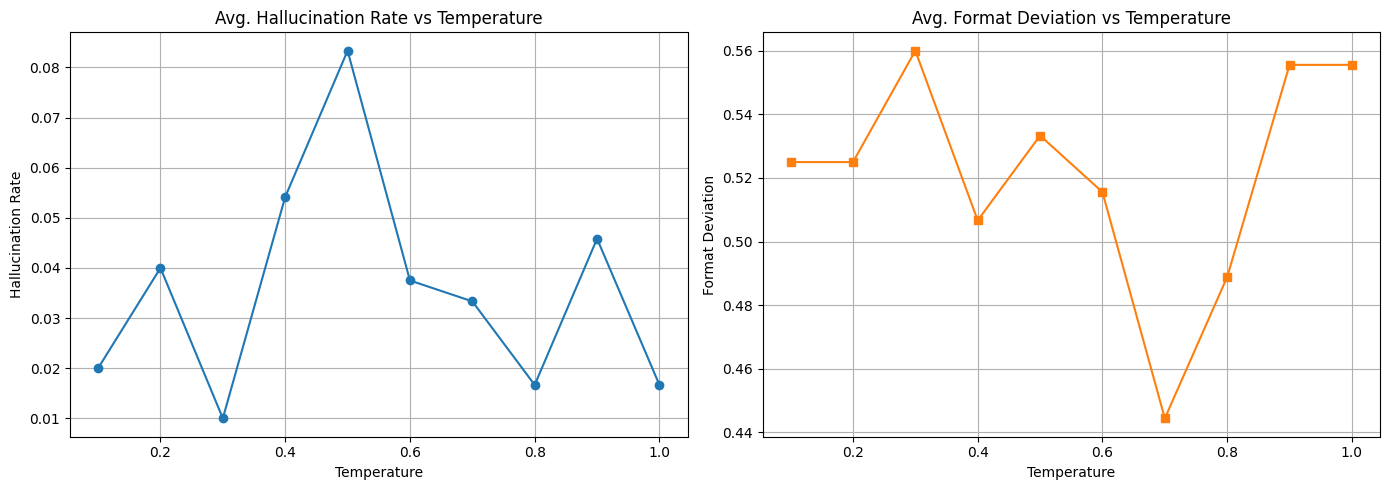

<Figure size 640x480 with 0 Axes>

In [222]:
# get results
df = pd.DataFrame(results_temp_df)

# Extract the numeric scores
df["hallucination_rate"] = df["hallucination"].apply(lambda x: x.get("hallucination_rate", None))
df["format_deviation"] = df["format"].apply(lambda x: x.get("Format deviation rate", None))

# Group by temperature and compute means
grouped = df.groupby("temperature").agg({
    "hallucination_rate": "mean",
    "format_deviation": "mean"
}).reset_index()

# --- Plot side-by-side ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

# Hallucination plot
axes[0].plot(grouped["temperature"], grouped["hallucination_rate"], marker='o', color='tab:blue')
axes[0].set_title("Avg. Hallucination Rate vs Temperature")
axes[0].set_xlabel("Temperature")
axes[0].set_ylabel("Hallucination Rate")
axes[0].grid(True)

# Format deviation plot
axes[1].plot(grouped["temperature"], grouped["format_deviation"], marker='s', color='tab:orange')
axes[1].set_title("Avg. Format Deviation vs Temperature")
axes[1].set_xlabel("Temperature")
axes[1].set_ylabel("Format Deviation")
axes[1].grid(True)

plt.tight_layout()
plt.show()

# save image
plt.savefig("temperature_experiment_results.png")

## 4.2 3/3 Context recall (time awareness) Test

In [15]:
# # ###########################################################################################

# Evaluate context recall from previous months outputs: corpus = summary(t-1), summary = summary(t).
# Using the severity score as a reference
def context_recall_judge(summary):
   
    prompt = f"""
You are an AI judge evaluating the time awareness (context recall) of a summary.
Your task is to guess whether the severity of the events described in the summary 
is higher, lower or the same as the severity of the events in the previous month.

Summary to evaluate:
{summary}

Your output must be severity trend code given to the summary, preceded by a "result" tag.
The code is "+" if the severity is higher, "0" if the severity is the same, and "-" if the severity is lower.
If the summary does not provide enough information to determine the trend, consider severity as similar and return 0.

    Output format:
    result <trend_code_of_the_summary>

    Your output can be only one of the following three codes:

    Output format for higher severity:
    result +

    Output format for same severity:
    result 0

    Output format for lower severity:
    result -

"""
    try:
        result = ask_llm(prompt, provider="mistral", temperature=0.2, max_tokens=5)

        # Extract +, 0, or - from the result
        match = re.search(r"result\s+([+\-0])", result.strip().lower())
        if match:
            return match.group(1)
        else:
            return {"error": "No valid trend code found in response", "raw_output": result}
    except Exception as e:
        return {"error": str(e), "raw_output": result if 'result' in locals() else None}


# fake summary with higher trend
higher_trend_summary = """
In February 2025, the severity of events in Georgia escalated significantly. Protests turned into violent clashes, resulting in a 30% increase in fatalities compared to January. The number of strategic developments also surged, indicating a deteriorating security situation."""
#fake summary with lower trend
lower_trend_summary = """
In February 2025, the situation in Georgia showed signs of improvement. Protests decreased by 40% compared to January, and there were no reported fatalities. Strategic developments also declined, suggesting a more stable environment."""
# fake summary with ambiguity (no reference to trend)
ambiguous_summary = test_summary

# Evaluate the context recall for the fake summaries
higher_trend_result = context_recall_judge(higher_trend_summary)
lower_trend_result = context_recall_judge(lower_trend_summary)
ambiguous_trend_result1 = context_recall_judge(ambiguous_summary)
ambiguous_trend_result2 = context_recall_judge(random_summary)

# Print the results
print("Higher trend summary result:", higher_trend_result)
print("Lower trend summary result:", lower_trend_result)
print("Ambiguous trend summary result 1:", ambiguous_trend_result1)
print("Ambiguous trend summary result 2:", ambiguous_trend_result2)

Higher trend summary result: +
Lower trend summary result: -
Ambiguous trend summary result 1: +
Ambiguous trend summary result 2: 0


In [107]:
# # ###########################################################################################

# function to evaluate context recall using previous context_recall_judge. Must be used with low thresholds for precision

def evaluate_context_recall(summary, severity_t, severity_t_minus_1, threshold=0.3, iterations=5):
    """
    Evaluate whether a summary correctly reflects the severity trend using LLM judgments.

    Args:
        summary (str): The summary to evaluate.
        severity_t (float): Severity at current time t.
        severity_t_minus_1 (float): Severity at previous time t-1.
        threshold (float): Difference threshold to distinguish trend.
        iterations (int): Number of valid evaluations to perform.

    Returns:
        dict: Contains average context deviation, accepted trends, and detailed results.
    """

    # Determine expected trend
    diff = severity_t - severity_t_minus_1
    if abs(diff) >= threshold:
        accepted = {'+'} if diff > 0 else {'-'}
    elif diff > 0:
        accepted = {'+', '0'}
    elif diff < 0:
        accepted = {'-', '0'}
    else:
        accepted = {'0'}

    def safe_call():
        try:
            result = context_recall_judge(summary)
            if isinstance(result, str) and result in {'+', '-', '0'}:
                return 0 if result in accepted else 1
        except Exception:
            pass
        return None

    # Run evaluations, retrying on failure until 'iterations' successful results
    scores = []
    with tqdm(total=iterations, desc="Evaluating context recall") as pbar:
        while len(scores) < iterations:
            with ThreadPoolExecutor() as executor:
                needed = iterations - len(scores)
                futures = [executor.submit(safe_call) for _ in range(needed)]
                for future in as_completed(futures):
                    score = future.result()
                    if score is not None:
                        scores.append(score)
                        pbar.update(1)

    return {
        "context_deviation": sum(scores) / iterations,
        "expected_trend": list(accepted),
        "iterations": iterations,
        "raw_deviation_flags": scores  # List of 0 (correct) or 1 (wrong)
    }

# -----------------------------------------------

# robust version of context evaluator

def evaluate_context_recall(summary, severity_t, severity_t_minus_1, threshold=0.3, iterations=5, max_errors=5):
    """
    Evaluate whether a summary correctly reflects the severity trend using LLM judgments.
    Returns 1.0 if too many errors occur during evaluation.

    Args:
        summary (str): The summary to evaluate.
        severity_t (float): Severity at current time t.
        severity_t_minus_1 (float): Severity at previous time t-1.
        threshold (float): Difference threshold to distinguish trend.
        iterations (int): Number of valid evaluations to perform.
        max_errors (int): Maximum number of failed attempts allowed before giving up.

    Returns:
        dict: Contains average context deviation, expected trends, and detailed results.
    """

    # Determine expected trend
    diff = severity_t - severity_t_minus_1
    if abs(diff) >= threshold:
        accepted = {'+'} if diff > 0 else {'-'}
    elif diff > 0:
        accepted = {'+', '0'}
    elif diff < 0:
        accepted = {'-', '0'}
    else:
        accepted = {'0'}

    def safe_call():
        try:
            result = context_recall_judge(summary)
            if isinstance(result, str) and result in {'+', '-', '0'}:
                return 0 if result in accepted else 1
        except Exception as e:
            print ("⚠️ Error during context recall evaluation:", str(e))
            pass
        return None

    # Run evaluations
    scores = []
    error_count = 0

    with tqdm(total=iterations, desc="Evaluating context recall") as pbar:
        while len(scores) < iterations:
            with ThreadPoolExecutor() as executor:
                needed = iterations - len(scores)
                futures = [executor.submit(safe_call) for _ in range(needed)]
                for future in as_completed(futures):
                    score = future.result()
                    if score is not None:
                        scores.append(score)
                        pbar.update(1)
                        error_count = 0  # reset on success
                    else:
                        error_count += 1
                        if error_count >= max_errors:
                            print("❌ Too many failed context recall evaluations. Aborting and returning max deviation.")
                            return {
                                "context_deviation": 1.0,
                                "expected_trend": list(accepted),
                                "iterations": len(scores),
                                "raw_deviation_flags": scores
                            }

    return {
        "context_deviation": sum(scores) / iterations,
        "expected_trend": list(accepted),
        "iterations": iterations,
        "raw_deviation_flags": scores
    }


In [246]:
# Example severity scores for testing


severity_t = 0.8  # Current severity score
severity_t_minus_1 = 0.5  # Previous severity score
# Evaluate context recall for the fake summaries
higher_trend_eval = evaluate_context_recall(
    summary=higher_trend_summary,
    severity_t=severity_t,
    severity_t_minus_1=severity_t_minus_1,
    threshold=0.1,
    iterations=5
)
lower_trend_eval = evaluate_context_recall(
    summary=lower_trend_summary,
    severity_t=severity_t,
    severity_t_minus_1=severity_t_minus_1,
    threshold=0.1,
    iterations=5
)
ambiguous_trend_eval1 = evaluate_context_recall(
    summary=ambiguous_summary,
    severity_t=severity_t,
    severity_t_minus_1=severity_t_minus_1,
    threshold=0.1,
    iterations=5
)

# Results of context deviation
print("Higher trend evaluation result:", higher_trend_eval)
print("Lower trend evaluation result:", lower_trend_eval)
print("Ambiguous trend evaluation result 1:", ambiguous_trend_eval1)

Evaluating context recall: 100%|██████████| 5/5 [00:00<00:00, 20.46it/s]

Higher trend evaluation result: {'context_deviation': 0.0, 'expected_trend': ['+'], 'iterations': 5, 'raw_deviation_flags': [0, 0, 0, 0, 0]}
Lower trend evaluation result: {'context_deviation': 1.0, 'expected_trend': ['+'], 'iterations': 5, 'raw_deviation_flags': [1, 1, 1, 1, 1]}
Ambiguous trend evaluation result 1: {'context_deviation': 0.0, 'expected_trend': ['+'], 'iterations': 5, 'raw_deviation_flags': [0, 0, 0, 0, 0]}


In [17]:
# Measure context recall for a random sample of summaries with context. At subregion/monthly level
df_all2 = df_all.copy()
# Compute severity score for each event based on the number of fatalities

# Define severity mappings for disorder_type and event_type
disorder_severity = {
    'Political violence': 0.7,
    'Violence against civilians': 0.9,
    'Strategic developments': 0.8,
    'Demonstrations': 0.5,
    'Political violence; Demonstrations': 1.0,
    'Protests': 0.3,
    'Riots': 0.5,
}

event_severity = {
    'Violence against civilians': 0.8,
    'Political violence': 0.7,
    'Battles': 0.8,
    'Explosions/Remote violence': 1.0,
    'Protests': 0.4,
    'Riots': 0.6,
    'Strategic developments': 0.9,
    'Peaceful protest': 0.2,
    'Attack': 0.9,
    'Arrests': 0.3
}

# Normalize fatalities (scale 0-1 based on max fatalities)
max_fatalities = df_all2['fatalities'].max()
df_all2['normalized_fatalities'] = df_all2['fatalities'] / max_fatalities if max_fatalities > 0 else 0

# Map severity scores for disorder_type and event_type
df_all2['disorder_severity'] = df_all2['disorder_type'].map(disorder_severity).fillna(0.1)
df_all2['event_severity'] = df_all2['event_type'].map(event_severity).fillna(0.1)

# Civilian targeting (binary: 1 if present, 0 if not)
df_all2['civilian_targeting_binary'] = df_all2['civilian_targeting'].notna().astype(int)

# Calculate per-event severity score (weighted average)
weights = {
    'fatalities': 0.1,
    'disorder_type': 0.3,
    'civilian_targeting': 0.3,
    'event_type': 0.3
}
df_all2['severity_score'] = (
    weights['fatalities'] * df_all2['normalized_fatalities'] +
    weights['disorder_type'] * df_all2['disorder_severity'] +
    weights['civilian_targeting'] * df_all2['civilian_targeting_binary'] +
    weights['event_type'] * df_all2['event_severity']
)

# Scale severity score to 0-100 for easier interpretation
df_all2['severity_score'] = df_all2['severity_score'] * 100


# Save the updated event-level CSV with severity_score
df_all2.to_csv("acled_data_severity.csv", index=False)
print(f"✅ Severity scores computed and saved")

df_all2.head()

✅ Severity scores computed and saved


,event_id_cnty,event_date,year,time_precision,disorder_type,event_type,sub_event_type,actor1,assoc_actor_1,inter1,...,source_scale,notes,fatalities,tags,timestamp,normalized_fatalities,disorder_severity,event_severity,civilian_targeting_binary,severity_score
0,MEX103926,2025-05-16,2025,1,Political violence,Violence against civilians,Abduction/forced disappearance,Unidentified Armed Group (Mexico),NaN,Political militia,...,Subnational,"On 16 May 2025, in Culiacan Rosales, Sinaloa, ...",0,NaN,1747779265,0.000000,0.7,0.8,1,75.000000
1,MEX103927,2025-05-16,2025,1,Political violence,Violence against civilians,Abduction/forced disappearance,Unidentified Armed Group (Mexico),NaN,Political militia,...,National,"On 16 May 2025, in Montemorelos, Nuevo Leon, a...",0,NaN,1747779265,0.000000,0.7,0.8,1,75.000000
2,MEX103944,2025-05-16,2025,1,Political violence,Battles,Armed clash,Unidentified Armed Group (Mexico),NaN,Political militia,...,National,"On 16 May 2025, in Montemorelos, Nuevo Leon, t...",4,NaN,1747779265,0.031496,0.7,0.8,0,45.314961
3,MEX103951,2025-05-16,2025,1,Political violence,Battles,Armed clash,Unidentified Armed Group (Mexico),NaN,Political militia,...,Subnational-National,"On 16 May 2025, in Juan Aldama (El Tigre), Sin...",0,NaN,1747779265,0.000000,0.7,0.8,0,45.000000
4,MEX103964,2025-05-16,2025,1,Political violence,Violence against civilians,Attack,Unidentified Armed Group (Mexico),NaN,Political militia,...,National,"On 16 May 2025, in Villahermosa, Tabasco, unid...",1,local administrators,1747779265,0.007874,0.7,0.8,1,75.078740


## 5. Prompt iteration

In [124]:
# # ###########################################################################################

# Improve prompt using combined metric.

# Modify the evaluation functions so that they return directly the numerical result. They should
# wrap the previous functions and return only the desired field

def evaluate_hallucination_numeric(summary, test_corpus, num_questions=20, manual=False, iterations=1):
    result = evaluate_hallucination(
        summary=summary,
        test_corpus=test_corpus,
        num_questions=num_questions,
        manual=manual,
        iterations=iterations
    )
    # 1 instead of None
    return result['hallucination_rate'] if result else 1

def evaluate_format_numeric(summary, length=500, iterations=5):
    result = evaluate_format(
        summary=summary,
        length=length,
        iterations=iterations
    )
    # 1 instead of None
    return result['Format deviation rate'] if result else 1

def evaluate_context_recall_numeric(summary, severity_t, severity_t_minus_1, threshold=0.3, iterations=5):
    result = evaluate_context_recall(
        summary=summary,
        severity_t=severity_t,
        severity_t_minus_1=severity_t_minus_1,
        threshold=threshold,
        iterations=iterations
    )
    # 1 instead of None
    return result['context_deviation'] if result else 1


# Modify the summarization function so that can take into account prompt improvements and sub_country level summaries

def summarize_events(
    uri,
    user,
    pwd,
    llm_provider="mistral",
    country="Mexico",
    state = None,
    event_type=None,
    month=2,
    year=2025,
    max_results=5000,
    context="",
    temperature=0.7,
    max_tokens=1000,
    override_prompt=None
):
    """
    Summarize events using a custom or template-based prompt.
    If `override_prompt` is passed, it will be used directly.
    """
    bullets, tot_events = query_events(
        uri=uri,
        user=user,
        pwd=pwd,
        year=year,
        month=month,
        country=country,
        state=state,
        event_type=event_type,
        max_results=max_results
    )

    print("✅ total events found:", tot_events)

    # Prompt logic
 #   prompt = override_prompt or build_summary_prompt(
 #       country=country,
 #       event_type=event_type,
 #       month=month,
 #       year=year,
 #       bullets=bullets,
 #       context=context
 #   )
    if override_prompt:
        prompt = override_prompt.format(
        bullets=bullets,
        context=context,
        country=country,
        state=state,
        event_type=event_type,
        month=month,
        year=year
    )
    else:
        prompt = build_summary_prompt(
        country=country,
        event_type=event_type,
        month=month,
        year=year,
        bullets=bullets,
        context=context
    )

    if not prompt.strip():
        return "No events found for the specified filters.", bullets

    # Query the LLM
    summary = ask_llm(
        prompt,
        provider=llm_provider,
        temperature=temperature,
        max_tokens=max_tokens
    )

    return summary, bullets



In [24]:
# # ###########################################################################################

# Procedure: 

# -> Select a sample of n regional corpus at t , n at t-1.
# -> At each step k:
#    -> Generate a summary without context for each corpus at t-1, and a summary with context at t.
#    -> Evaluate each summary at t using the combined metric (against the trend and the corpus at t, t-1?).
#    -> Avg the results across the n samples (cross validation)
#    -> Refine the prompt if early stop is not reached (when the error is low enough after m steps) in the same conversation!! (passing the metrics results)




In [125]:
# # ###########################################################################################

# function to refine prompts in the same llm conversation (high temperature for more exploration)

def refine_prompt(previous_messages, last_metrics, target_metric=None, temperature=0.7):
    """
    Refine a prompt based on previous conversation and performance metrics.
    Returns only the new prompt, which is enclosed between <<REFINED_PROMPT>> and <</REFINED_PROMPT>>.
    """

    system_message = {
        "role": "system",
        "content": (
            "You are an expert in prompt optimization for summarization of key developments from a set of events. "
            "The summaries should not invent facts, should have a clear format, and should reflect awareness of prior context. "
            "Return only the **refined prompt enclosed between**:\n"
            "`<<REFINED_PROMPT>>` and `<</REFINED_PROMPT>>`"
        )
    }

    metrics_summary = "\n".join(f"{k}: {v}" for k, v in last_metrics.items())

    user_content = (
        f"Here are the latest evaluation metrics for the previous prompts:\n\n"
        f"{metrics_summary}\n\n"
        f"Focus on improving {'all metrics' if target_metric is None else target_metric}. "
        f"Based on the context of the previous conversation, please suggest a refined version of the prompt."
    )

    user_message = {"role": "user", "content": user_content}
    new_conversation = [system_message] + previous_messages + [user_message]

    try:
        response = ask_llm(
            prompt="",
            previous_messages=new_conversation,
            temperature=temperature,
            max_tokens=500
        )

        # Extract the prompt between the distinctive tags
        match = re.search(r"<<REFINED_PROMPT>>(.*?)<</REFINED_PROMPT>>", response, re.DOTALL | re.IGNORECASE)
        if match:
            return match.group(1).strip()
        else:
            print("error ⚠️ Refined prompt not found in tags — returning full response.")
            return response.strip()

    except Exception as e:
        return f"error during prompt refinement: {e}"

#-----------------------------------------------------------------  

def refine_prompt(previous_conversation, temperature=0.7):
 


    # --- System message with few-shot structure ---
    system_message = {
        "role": "system",
        "content": (
            "You are an expert in prompt engineering for summarization tasks in the conflict early-warning domain.\n"
            "You will be provided with a series of prompt-performance pairs. Your job is to suggest an improved prompt that minimizes avg deviation score through:\n"
            "- Minimizing hallucination rate\n"
            "- Improving summary format (minimizing format deviation\n"
            "- Improving awareness of prior context (minimizing context deviation) \n\n"
            "The prompt must follow a consistent structure and use the following parameter placeholders:\n"
            "- {event_type}, {country}, {month}, {year}, {context}, {bullets}\n\n"
            "Example prompt format:\n"
            "prompt <START>\n"
            "You are an analyst writing a conflict-early-warning brief.\n"
            "Summarise key developments of type {event_type} in {country}, {month} {year}.\n\n"
            "Context\n"
            "-------\n"
            "Key developments in previous month : {context}\n\n"
            "Key events\n"
            "----------\n"
            "{bullets}\n\n"
            "Task\n"
            "----\n"
            "Provide a concise summary. Cite Event IDs in parentheses. Do **not** invent facts.\n"
            "prompt <END>\n\n"
            "Now, return a refined version enclosed between 'prompt <START>' and 'prompt <END>'."
        )
    }

    # --- User message construction with prompt-history + metrics ---
    user_lines = ["Here are the previous prompts and their evaluation metrics:\n"]
    for i, (prompt, metrics) in enumerate(previous_conversation):
        user_lines.append(f"Prompt {i + 1}:\n{prompt.strip()}")
        user_lines.append("Metrics:")
        for k, v in metrics.items():
            user_lines.append(f"- {k}: {v}")
        user_lines.append("")

    user_message = {
        "role": "user",
        "content": "\n".join(user_lines)
    }

    # --- Full conversation ---
    conversation = [system_message, user_message]

    # --- Ask the LLM ---
    try:
        raw_output = ask_llm(
            prompt="",  # Conversation comes via previous_messages
            previous_messages=conversation,
            temperature=temperature,
            max_tokens=600
        )

        # Extract refined prompt between tags
        match = re.search(r"prompt\s*<START>(.*?)prompt\s*<END>", raw_output, re.DOTALL | re.IGNORECASE)
        if match:
            return match.group(1).strip()
        else:
            return f"Error: Could not extract prompt from response.\n\nRaw output:\n{raw_output}"

    except Exception as e:
        return f"Error during prompt refinement: {e}"


# first message to pass to previous messages should be the original prompt + previous metrics


In [169]:
# # ###########################################################################################

import random
from concurrent.futures import ThreadPoolExecutor
from collections import Counter
import numpy as np

# --------------------------------------------
def count_tokens(text):
    """Estimate the number of tokens in a text string."""
    return len(text.split())
# --------------------------------------------

# version with test dataset

def run_prompt_refinement_experiment_custom(
    df,
    n_samples=5,
    temperature=0.7,
    max_tokens=1000,
    uri=None,
    user=None,
    pwd=None,
    threshold=0.5,
    early_stop_threshold=0.05,
    max_steps=5,
    max_corpus_tokens=25000
):
    print("📊 Starting prompt refinement experiment...")
    df = df.copy()
    df['month'] = pd.to_datetime(df['event_date']).dt.month

    eligible_rows = df.dropna(subset=['severity_score'])
    triplets = list(eligible_rows.groupby(['country', 'month', 'admin1']).groups.keys())
    valid_triplets = [
        (c, m, a) for (c, m, a) in triplets if m > 1 and (c, m - 1, a) in triplets
    ]
    sample_triplets = random.sample(valid_triplets, min(n_samples, len(valid_triplets)))

    initial_prompt = refine_prompt([], temperature=0.5)
    if not initial_prompt or not initial_prompt.strip():
        raise ValueError("Initial prompt is empty. refine_prompt() returned nothing.")

    #conversation = [(initial_prompt, {"average_deviation": None, "step": 0})]
    conversation = []
    new_prompt = initial_prompt
    step_scores = []

    # 🔽 ADDED: store all (prompt, score) pairs
    #all_prompts = [(initial_prompt, 1.0)]
    all_prompts=[]

    for step in range(max_steps):
        print(f"\n🚀 Step {step + 1}/{max_steps}")
        deviation_scores = []
        #-----
        hallucination_scores = []
        format_scores = []
        context_scores = []
        #-----

        for (country, month, admin1) in sample_triplets:
            df_t = df[(df['country'] == country) & (df['month'] == month) & (df['admin1'] == admin1)]
            df_t1 = df[(df['country'] == country) & (df['month'] == month - 1) & (df['admin1'] == admin1)]

            corpus_t = "\n".join(df_t['notes'].dropna())
            corpus_t1 = "\n".join(df_t1['notes'].dropna())
            corpus = corpus_t + "\n" + corpus_t1

            if count_tokens(corpus_t) > max_corpus_tokens or count_tokens(corpus_t1) > max_corpus_tokens:
                print(f"⚠️ Skipped {country}, {month}, {admin1} due to large corpus size.")
                continue

            sev_t = df_t['severity_score'].mean()
            sev_t1 = df_t1['severity_score'].mean()

            summary_t1, _ = summarize_events(
                uri=uri, user=user, pwd=pwd,
                llm_provider="mistral",
                country=country, event_type=None, month=month - 1, year=2025,
                state=admin1,
                temperature=temperature,
                context=None,
                max_tokens=max_tokens,
                override_prompt=None
            )

            summary, _ = summarize_events(
                uri=uri, user=user, pwd=pwd,
                llm_provider="mistral",
                country=country, event_type=None, month=month, year=2025,
                state=admin1,
                temperature=temperature,
                context=summary_t1,
                max_tokens=max_tokens,
                override_prompt=new_prompt
            )

            print("🧪 Evaluating step...")
            hall_score = evaluate_hallucination_numeric(summary, corpus, num_questions=20, manual=True, iterations=1)
            fmt_score = evaluate_format_numeric(summary, length=500, iterations=1)
            ctx_score = evaluate_context_recall_numeric(summary, sev_t, sev_t1, threshold=threshold, iterations=1)

            total_score = (hall_score + fmt_score + ctx_score) / 3
            deviation_scores.append(total_score)
            #-------
            hallucination_scores.append(hall_score)
            format_scores.append(fmt_score)
            context_scores.append(ctx_score)
            #-------

        if not deviation_scores:
            print("❌ No valid samples at this step. Skipping...")
            continue

        avg_score = np.mean(deviation_scores)
        #-------
        hall_score = np.mean(hallucination_scores)
        fmt_score = np.mean(format_scores)
        ctx_score = np.mean(context_scores)
        #-------
        #step_scores.append(avg_score)
        step_scores.append((avg_score, hall_score, fmt_score, ctx_score))

        print(f"✅ Average deviation score at step {step + 1}: {avg_score:.3f}")

        # 🔽 ADDED: store prompt + score
        all_prompts.append((new_prompt, avg_score))

        if avg_score <= early_stop_threshold:
            print("🛑 Early stopping threshold reached.")
            break

        last_metrics = {
            "average_deviation": avg_score,
            "step": step + 1,
            "hallucination_rate": hall_score,
            "format_deviation": fmt_score,
            "context_deviation": ctx_score
        }
        conversation.append((new_prompt, last_metrics))

        max_retries = 3
        for attempt in range(max_retries):
            new_prompt = refine_prompt(conversation)

            if isinstance(new_prompt, str) and new_prompt.strip() and not new_prompt.lower().startswith("error"):
                break
            else:
                print(f"🔁 Retry {attempt + 1}/{max_retries}: refine_prompt() returned invalid result.")
                new_prompt = None

        if not new_prompt:
            print("❌ Failed to get a valid refined prompt after retries. Stopping experiment.")
            break

      #  conversation.append((new_prompt, last_metrics))

    # 🔽 ADDED: Final test evaluation on best prompt
    best_prompt, best_score = sorted(all_prompts, key=lambda x: x[1])[0]
    print(f"\n🏁 Best prompt selected (score {best_score:.3f}). Evaluating on test case...")
    print("Best prompt:\n", best_prompt)
    
    # Select a random valid test case
    test_triplet = random.choice(valid_triplets)
    test_df_t = df[(df['country'] == test_triplet[0]) & (df['month'] == test_triplet[1]) & (df['admin1'] == test_triplet[2])]
    test_df_t1 = df[(df['country'] == test_triplet[0]) & (df['month'] == test_triplet[1] - 1) & (df['admin1'] == test_triplet[2])]

    test_corpus = "\n".join(test_df_t['notes'].dropna()) + "\n" + "\n".join(test_df_t1['notes'].dropna())
    test_sev_t = test_df_t['severity_score'].mean()
    test_sev_t1 = test_df_t1['severity_score'].mean()

    test_summary_t1, _ = summarize_events(
        uri=uri, user=user, pwd=pwd,
        llm_provider="mistral",
        country=test_triplet[0], event_type=None, month=test_triplet[1] - 1, year=2025,
        state=test_triplet[2],
        temperature=temperature,
        context=None,
        max_tokens=max_tokens,
        override_prompt=None
    )

    test_summary, _ = summarize_events(
        uri=uri, user=user, pwd=pwd,
        llm_provider="mistral",
        country=test_triplet[0], event_type=None, month=test_triplet[1], year=2025,
        state=test_triplet[2],
        temperature=temperature,
        context=test_summary_t1,
        max_tokens=max_tokens,
        override_prompt=best_prompt
    )

    print("🧪 Final evaluation on test summary...")
    final_hall = evaluate_hallucination_numeric(test_summary, test_corpus, num_questions=20, manual=True, iterations=1)
    final_fmt = evaluate_format_numeric(test_summary, length=500, iterations=1)
    final_ctx = evaluate_context_recall_numeric(test_summary, test_sev_t, test_sev_t1, threshold=threshold, iterations=1)

    final_score = (final_hall + final_fmt + final_ctx) / 3
    print(f"✅ Final test deviation score: {final_score:.3f}")

    return step_scores, best_prompt, final_score

In [148]:
# run (TRY WITH LOW TEMPERATURE FOR ROBUST RESULTS)

step_scores, final_prompt, final_score = run_prompt_refinement_experiment_custom(        
    df=df_all2,
    n_samples=5,
    temperature=0.2,  # 0.7
    max_tokens=1000,
    uri=BOLT_URI,
    user=USER,
    pwd=PWD,
    threshold=0.1,  # For context recall evaluation
    early_stop_threshold=0.05,  
    max_steps=12
)

📊 Starting prompt refinement experiment...

🚀 Step 1/12
✅ total events found: 14
✅ total events found: 11
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:06<00:00,  3.23s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]


✅ total events found: 1
✅ total events found: 2
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:40<00:00, 20.03s/it]


Hallucination rate: 0.050000000000000044


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


Format deviation rate: 0.0


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


✅ total events found: 35
✅ total events found: 20
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:15<00:00,  7.89s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]


✅ total events found: 39
✅ total events found: 5
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:41<00:00, 20.89s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  2.84it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]


✅ total events found: 21
✅ total events found: 21
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:07<00:00,  3.67s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


Format deviation rate: 0.4


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]


✅ Average deviation score at step 1: 0.203
🔁 Retry 1/3: refine_prompt() returned invalid result.

🚀 Step 2/12
✅ total events found: 14
✅ total events found: 11
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:09<00:00,  4.87s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]


✅ total events found: 1
✅ total events found: 2
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:12<00:00,  6.01s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  3.59it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall:   0%|          | 0/1 [00:01<?, ?it/s]

❌ Too many failed context recall evaluations. Aborting and returning max deviation.
✅ total events found: 35


✅ total events found: 20
🧪 Evaluating step...
Error found. Retrying to generate questions at step 1.


Evaluating: 100%|██████████| 2/2 [00:05<00:00,  2.95s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  4.10it/s]


✅ total events found: 39
✅ total events found: 5
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [01:08<00:00, 34.06s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


✅ total events found: 21
✅ total events found: 21
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:08<00:00,  4.25s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]


✅ Average deviation score at step 2: 0.267

🚀 Step 3/12
✅ total events found: 14
✅ total events found: 11
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:12<00:00,  6.00s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  4.10it/s]


Format deviation rate: 0.0


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  4.06it/s]


✅ total events found: 1
✅ total events found: 2
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:05<00:00,  2.81s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  4.10it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


✅ total events found: 35
✅ total events found: 20
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:11<00:00,  5.74s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


✅ total events found: 39
✅ total events found: 5
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:16<00:00,  8.04s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


Format deviation rate: 0.0


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]


✅ total events found: 21
✅ total events found: 21
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:49<00:00, 24.66s/it]


Hallucination rate: 0.09999999999999998


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  3.47it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]


✅ Average deviation score at step 3: 0.180

🚀 Step 4/12
✅ total events found: 14
✅ total events found: 11
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:07<00:00,  3.52s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  1.91it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


✅ total events found: 1
✅ total events found: 2
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:17<00:00,  8.65s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  3.51it/s]


Format deviation rate: 0.0


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


✅ total events found: 35
✅ total events found: 20
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:10<00:00,  5.02s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


✅ total events found: 39
✅ total events found: 5
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:06<00:00,  3.17s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  4.31it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  3.47it/s]


✅ total events found: 21
✅ total events found: 21
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:30<00:00, 15.26s/it]


Hallucination rate: 0.050000000000000044


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


Format deviation rate: 0.4


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]


✅ Average deviation score at step 4: 0.270

🚀 Step 5/12
✅ total events found: 14
✅ total events found: 11
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:17<00:00,  8.89s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  3.53it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]


✅ total events found: 1
✅ total events found: 2
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:07<00:00,  3.90s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]


✅ total events found: 35
✅ total events found: 20
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:06<00:00,  3.25s/it]


Hallucination rate: 0.050000000000000044


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


✅ total events found: 39
✅ total events found: 5
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:13<00:00,  6.91s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


✅ total events found: 21
✅ total events found: 21
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:07<00:00,  3.75s/it]


Hallucination rate: 0.15000000000000002


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]


Format deviation rate: 0.4


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]


✅ Average deviation score at step 5: 0.227

🚀 Step 6/12
✅ total events found: 14
✅ total events found: 11
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:06<00:00,  3.24s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]


✅ total events found: 1
✅ total events found: 2
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:21<00:00, 10.51s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


✅ total events found: 35
✅ total events found: 20
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:06<00:00,  3.02s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


✅ total events found: 39
✅ total events found: 5
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [01:49<00:00, 54.73s/it] 


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  4.03it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


✅ total events found: 21
✅ total events found: 21
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:07<00:00,  3.59s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Format deviation rate: 0.4


Evaluating context recall:   0%|          | 0/1 [00:01<?, ?it/s]

❌ Too many failed context recall evaluations. Aborting and returning max deviation.
✅ Average deviation score at step 6: 0.280



🚀 Step 7/12
✅ total events found: 14
✅ total events found: 11
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:15<00:00,  7.83s/it]


Hallucination rate: 0.050000000000000044


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]


✅ total events found: 1
✅ total events found: 2
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:05<00:00,  2.87s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  2.05it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]


✅ total events found: 35
✅ total events found: 20
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:05<00:00,  2.66s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


✅ total events found: 39
✅ total events found: 5
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:21<00:00, 10.85s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  1.94it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


✅ total events found: 21
✅ total events found: 21
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:26<00:00, 13.11s/it]


Hallucination rate: 0.050000000000000044


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]


Format deviation rate: 0.4


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


✅ Average deviation score at step 7: 0.220

🚀 Step 8/12
✅ total events found: 14
✅ total events found: 11
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:16<00:00,  8.29s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]


✅ total events found: 1
✅ total events found: 2
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:16<00:00,  8.19s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  4.08it/s]


✅ total events found: 35
✅ total events found: 20
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:11<00:00,  5.88s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


✅ total events found: 39
✅ total events found: 5
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:13<00:00,  6.65s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


✅ total events found: 21
✅ total events found: 21
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:11<00:00,  5.89s/it]


Hallucination rate: 0.09999999999999998


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  3.53it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]


✅ Average deviation score at step 8: 0.207

🚀 Step 9/12
✅ total events found: 14
✅ total events found: 11
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:19<00:00,  9.83s/it]


Hallucination rate: 0.050000000000000044


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  3.01it/s]


✅ total events found: 1
✅ total events found: 2
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:06<00:00,  3.43s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


✅ total events found: 35
✅ total events found: 20
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:05<00:00,  2.87s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


✅ total events found: 39
✅ total events found: 5
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:15<00:00,  7.88s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  4.03it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


✅ total events found: 21
✅ total events found: 21
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:07<00:00,  3.83s/it]


Hallucination rate: 0.09999999999999998


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  1.91it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]


✅ Average deviation score at step 9: 0.277

🚀 Step 10/12
✅ total events found: 14
✅ total events found: 11
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:07<00:00,  3.58s/it]


Hallucination rate: -0.10000000000000009


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


✅ total events found: 1
✅ total events found: 2
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:06<00:00,  3.23s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


✅ total events found: 35
✅ total events found: 20
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:15<00:00,  7.98s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


✅ total events found: 39
✅ total events found: 5
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:06<00:00,  3.12s/it]


Hallucination rate: 0.09999999999999998


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


Format deviation rate: 0.0


Evaluating context recall: 100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


✅ total events found: 21
✅ total events found: 21
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:07<00:00,  3.94s/it]


Hallucination rate: 0.15000000000000002


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]


Format deviation rate: 0.4


Evaluating context recall: 100%|██████████| 1/1 [00:01<00:00,  1.63s/it]


✅ Average deviation score at step 10: 0.143

🚀 Step 11/12
✅ total events found: 14
✅ total events found: 11
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:11<00:00,  5.88s/it]


Hallucination rate: 0.050000000000000044


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  3.65it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall:   0%|          | 0/1 [00:04<?, ?it/s]

❌ Too many failed context recall evaluations. Aborting and returning max deviation.
✅ total events found: 1


✅ total events found: 2
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:18<00:00,  9.16s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]


Format deviation rate: 0.0


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


✅ total events found: 35
✅ total events found: 20
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:17<00:00,  8.65s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]


Format deviation rate: 0.4


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]


✅ total events found: 39
✅ total events found: 5
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:07<00:00,  3.67s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  4.11it/s]


Format deviation rate: 0.0


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


✅ total events found: 21
✅ total events found: 21
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:09<00:00,  4.91s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]


Format deviation rate: 0.4


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


✅ Average deviation score at step 11: 0.203

🚀 Step 12/12
✅ total events found: 14
✅ total events found: 11
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:12<00:00,  6.09s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  3.53it/s]


✅ total events found: 1
✅ total events found: 2
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:18<00:00,  9.11s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


✅ total events found: 35
✅ total events found: 20
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:05<00:00,  2.89s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


Format deviation rate: 0.4


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


✅ total events found: 39
✅ total events found: 5
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:11<00:00,  5.51s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


✅ total events found: 21
✅ total events found: 21
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:07<00:00,  3.69s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]


✅ Average deviation score at step 12: 0.213

🏁 Best prompt selected (score 0.143). Evaluating on test case...
Best prompt:
 You are an analyst writing a conflict-early-warning brief.
Summarise key developments of type {event_type} in {country}, {month} {year}.

Context
-------
Key developments in previous month : {context}

Key events
----------
{bullets}

Task
----
Provide a concise summary. Cite Event IDs in parentheses. Do **not** invent facts.

Focus on the following aspects:
- Who was involved?
- What happened?
- When and where did it occur?
- What were the outcomes or impacts?
- How do these events relate to the previous month's context?

Use bullet points to list the key events and their impacts. Include a brief overview sentence that ties the summary to the broader context of conflict early warning. Ensure the summary is:
1. Accurate and factual: Do **not** invent or speculate about any information.
2. Well-structured: Follow a clear and logical format, using bullet points or s

Evaluating: 100%|██████████| 2/2 [00:33<00:00, 16.69s/it]


Hallucination rate: 0.050000000000000044


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]

✅ Final test deviation score: 0.083


In [149]:
# Difference between summaries before/after refinement
print("Final score after refinement:", final_score)
print("Final prompt after refinement:")
print(final_prompt)


Final score after refinement: 0.08333333333333333
Final prompt after refinement:
You are an analyst writing a conflict-early-warning brief.
Summarise key developments of type {event_type} in {country}, {month} {year}.

Context
-------
Key developments in previous month : {context}

Key events
----------
{bullets}

Task
----
Provide a concise summary. Cite Event IDs in parentheses. Do **not** invent facts.

Focus on the following aspects:
- Who was involved?
- What happened?
- When and where did it occur?
- What were the outcomes or impacts?
- How do these events relate to the previous month's context?

Use bullet points to list the key events and their impacts. Include a brief overview sentence that ties the summary to the broader context of conflict early warning. Ensure the summary is:
1. Accurate and factual: Do **not** invent or speculate about any information.
2. Well-structured: Follow a clear and logical format, using bullet points or short paragraphs.
3. Contextually aware: Inc

In [150]:
# Example usage of the final prompt to write a summary

# Select a sample test triplet (adjust if needed)
sample_triplet = ("Mexico", 3, "Mexico")  # example: Mexico, February, Guerrero

# common summary for t-1
non_refined_summary_t1, _ = summarize_events(
    uri=BOLT_URI,
    user=USER,
    pwd=PWD,
    llm_provider="mistral",
    country=sample_triplet[0],
    event_type="Protests",
    month=sample_triplet[1]-1,
    year=2025,
    state=sample_triplet[2],
    temperature=0.7,
    context="",
    max_tokens=1000,
    override_prompt=None
)

non_refined_summary, _ = summarize_events(
    uri=BOLT_URI,
    user=USER,
    pwd=PWD,
    llm_provider="mistral",
    country=sample_triplet[0],
    event_type="Protests",
    month=sample_triplet[1],
    year=2025,
    state=sample_triplet[2],
    temperature=0.7,
    context=non_refined_summary_t1,
    max_tokens=1000,
    override_prompt=None
)

# Summarize with final prompt
refined_summary, _ = summarize_events(
    uri=BOLT_URI,
    user=USER,
    pwd=PWD,
    llm_provider="mistral",
    country=sample_triplet[0],
    event_type="Protests",
    month=sample_triplet[1],
    year=2025,
    state=sample_triplet[2],
    temperature=0.7,
    context=non_refined_summary_t1,
    max_tokens=1000,
    override_prompt=final_prompt
)

print("\n📝 Non-refined Summary for Mexico, Mexico DF (Feb):\n")
print(non_refined_summary)
print("\n📄 Sample Summary using Final Refined Promp for Mexico, Mexico DF (Feb) t:\n")
print(refined_summary)

✅ total events found: 50
✅ total events found: 47
✅ total events found: 47

📝 Non-refined Summary for Mexico, Mexico DF (Feb):

### Summary of Key Protest Developments in Mexico, March 2025

**Early March:**
- **Violence and Labor Disputes:** A fatal incident occurred in Tlalnepantla where armed individuals shot at union members, resulting in one death and one injury (MEX101013). In the same area, tow truck drivers protested over control of the tow truck service, leading to arrests and clashes with police (MEX100572).
- **Environmental and Health Concerns:** Residents and municipal authorities in Temascalapa protested against the Radioactive Waste Storage Center, citing health and environmental risks (MEX100568). Public drivers in Tecamac de Felipe Villanueva blocked streets to protest against the invasion of their routes by an Expresso route (MEX100567).
- **Labor and Educational Issues:** Academic workers in Texcoco de Mora went on strike demanding better labor conditions, including 

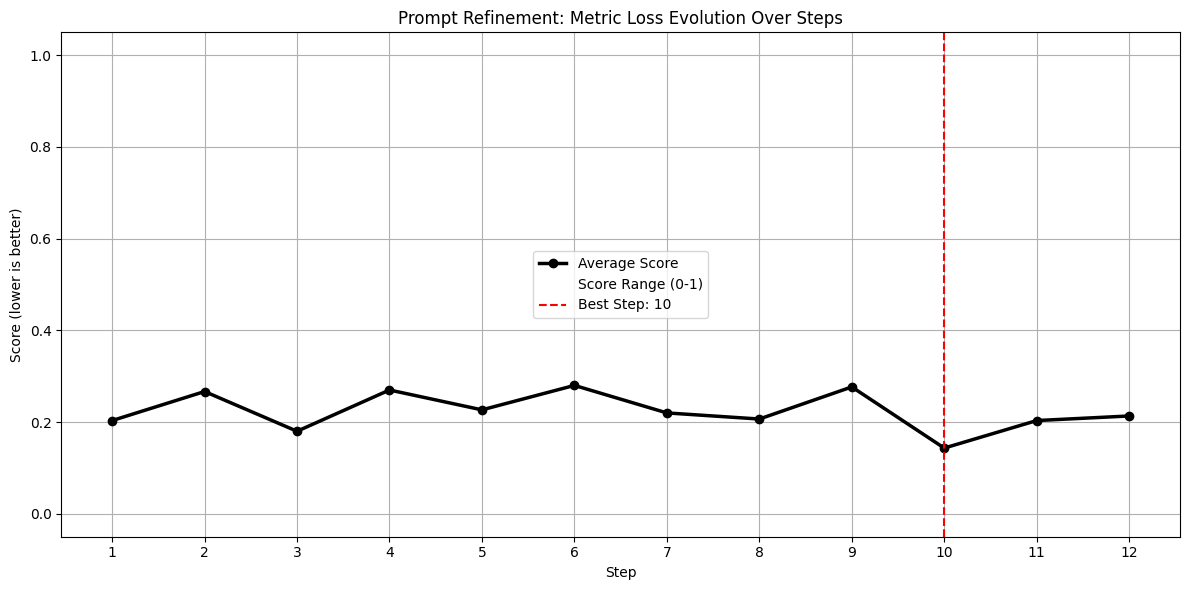

In [163]:
import matplotlib.pyplot as plt

# Unpack the individual scores
avg_scores = [s[0] for s in step_scores]
hall_scores = [s[1] for s in step_scores]
fmt_scores = [s[2] for s in step_scores]
ctx_scores = [s[3] for s in step_scores]

steps = list(range(1, len(step_scores) + 1))

plt.figure(figsize=(12, 6))
# highlight the average score
plt.plot(steps, avg_scores, marker='o', label='Average Score',  linewidth=2.5, color='black')
# plot all the y range
plt.fill_between(steps, 0, 1, color='white', alpha=0.5, label='Score Range (0-1)')
#plt.plot(steps, hall_scores, label='Hallucination Score', linewidth=1.5)
#plt.plot(steps, fmt_scores, label='Format Score', linewidth=1.5)
#plt.plot(steps, ctx_scores, label='Context Score', linewidth=1.5)
# line at the best score step
best_step_line = np.argmin(avg_scores) + 1
plt.axvline(best_step_line, color='red', linestyle='--', label=f'Best Step: {best_step_line}')

plt.title("Prompt Refinement: Metric Loss Evolution Over Steps")
plt.xlabel("Step")
plt.ylabel("Score (lower is better)")
plt.xticks(steps)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [170]:
# experiment with lowest temperature 

step_scores2, final_prompt2, final_score2 = run_prompt_refinement_experiment_custom(        
    df=df_all2,
    n_samples=5,
    temperature=0.2,  # 0.7
    max_tokens=1000,
    uri=BOLT_URI,
    user=USER,
    pwd=PWD,
    threshold=0.1,  # For context recall evaluation
    early_stop_threshold=0.05,  
    max_steps=12
)

📊 Starting prompt refinement experiment...

🚀 Step 1/12
✅ total events found: 89
✅ total events found: 121
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:06<00:00,  3.32s/it]


Hallucination rate: 0.050000000000000044


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  2.50it/s]


Format deviation rate: 0.4


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]


✅ total events found: 31
✅ total events found: 45
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:05<00:00,  2.73s/it]


Hallucination rate: 0.050000000000000044


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall:   0%|          | 0/1 [00:02<?, ?it/s]

❌ Too many failed context recall evaluations. Aborting and returning max deviation.
✅ total events found: 47


✅ total events found: 20
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:11<00:00,  5.67s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


Format deviation rate: 0.0


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]


✅ total events found: 118
✅ total events found: 140
🧪 Evaluating step...
Error found. Retrying to generate questions at step 1.


Evaluating: 100%|██████████| 2/2 [00:10<00:00,  5.08s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  2.50it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall:   0%|          | 0/1 [00:02<?, ?it/s]

❌ Too many failed context recall evaluations. Aborting and returning max deviation.
✅ total events found: 1


✅ total events found: 5
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:05<00:00,  2.52s/it]


Hallucination rate: 0.09999999999999998


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]


Format deviation rate: 0.0


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]


✅ Average deviation score at step 1: 0.400

🚀 Step 2/12
✅ total events found: 89
✅ total events found: 121
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:16<00:00,  8.09s/it]


Hallucination rate: 0.050000000000000044


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  2.50it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


✅ total events found: 31
✅ total events found: 45
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:55<00:00, 27.80s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


✅ total events found: 47
✅ total events found: 20
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:06<00:00,  3.32s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]


✅ total events found: 118
✅ total events found: 140
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:08<00:00,  4.09s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


✅ total events found: 1
✅ total events found: 5
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:06<00:00,  3.24s/it]


Hallucination rate: 0.19999999999999996


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]


✅ Average deviation score at step 2: 0.350

🚀 Step 3/12
✅ total events found: 89
✅ total events found: 121
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:15<00:00,  7.98s/it]


Hallucination rate: 0.050000000000000044


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]


✅ total events found: 31
✅ total events found: 45
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:15<00:00,  7.63s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


✅ total events found: 47
✅ total events found: 20
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:07<00:00,  3.73s/it]


Hallucination rate: 0.050000000000000044


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]


Format deviation rate: 0.0


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  4.35it/s]


✅ total events found: 118
✅ total events found: 140
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:06<00:00,  3.48s/it]


Hallucination rate: 0.050000000000000044


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


✅ total events found: 1
✅ total events found: 5
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:29<00:00, 14.90s/it]


Hallucination rate: 0.15000000000000002


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


✅ Average deviation score at step 3: 0.273

🚀 Step 4/12
✅ total events found: 89
✅ total events found: 121
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:06<00:00,  3.37s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  2.50it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]


✅ total events found: 31
✅ total events found: 45
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:30<00:00, 15.31s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]


✅ total events found: 47
✅ total events found: 20
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:09<00:00,  4.91s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]


✅ total events found: 118
✅ total events found: 140
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:20<00:00, 10.03s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  4.33it/s]


✅ total events found: 1
✅ total events found: 5
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:06<00:00,  3.38s/it]


Hallucination rate: 0.050000000000000044


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]


✅ Average deviation score at step 4: 0.337

🚀 Step 5/12
✅ total events found: 89
✅ total events found: 121
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:26<00:00, 13.13s/it]


Hallucination rate: -0.10000000000000009


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]


✅ total events found: 31
✅ total events found: 45
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:17<00:00,  8.93s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


✅ total events found: 47
✅ total events found: 20
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:09<00:00,  4.87s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


Format deviation rate: 0.0


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]


✅ total events found: 118
✅ total events found: 140
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:22<00:00, 11.21s/it]


Hallucination rate: 0.15000000000000002


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  1.94it/s]


Format deviation rate: 0.0


Evaluating context recall:   0%|          | 0/1 [00:01<?, ?it/s]

❌ Too many failed context recall evaluations. Aborting and returning max deviation.
✅ total events found: 1


✅ total events found: 5
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:11<00:00,  5.81s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  3.46it/s]


Format deviation rate: 0.0


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


✅ Average deviation score at step 5: 0.297

🚀 Step 6/12
✅ total events found: 89
✅ total events found: 121
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:14<00:00,  7.26s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]


✅ total events found: 31
✅ total events found: 45
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:09<00:00,  4.91s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


✅ total events found: 47
✅ total events found: 20
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:22<00:00, 11.00s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  4.06it/s]


Format deviation rate: 0.0


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


✅ total events found: 118
✅ total events found: 140
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:08<00:00,  4.09s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]


✅ total events found: 1
✅ total events found: 5
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:05<00:00,  2.76s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


✅ Average deviation score at step 6: 0.320

🚀 Step 7/12
✅ total events found: 89
✅ total events found: 121
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:07<00:00,  3.58s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


✅ total events found: 31
✅ total events found: 45
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:18<00:00,  9.22s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


Format deviation rate: 0.4


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


✅ total events found: 47
✅ total events found: 20
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:10<00:00,  5.47s/it]


Hallucination rate: 0.09999999999999998


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]


Format deviation rate: 0.0


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


✅ total events found: 118
✅ total events found: 140
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:08<00:00,  4.45s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]


Format deviation rate: 0.0


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  3.53it/s]


✅ total events found: 1
✅ total events found: 5
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:05<00:00,  2.91s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


Format deviation rate: 0.0


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  3.53it/s]


✅ Average deviation score at step 7: 0.313

🚀 Step 8/12
✅ total events found: 89
✅ total events found: 121
🧪 Evaluating step...
Error found. Retrying to generate questions at step 1.
Error found. Retrying to generate questions at step 1.
Error found. Retrying to generate questions at step 11.
Error found. Retrying to generate questions at step 11.
Error found. Retrying to generate questions at step 11.


Evaluating: 100%|██████████| 2/2 [00:07<00:00,  3.85s/it]


Hallucination rate: 0.050000000000000044


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


✅ total events found: 31
✅ total events found: 45
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:06<00:00,  3.12s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


Format deviation rate: 0.0


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  3.62it/s]


✅ total events found: 47
✅ total events found: 20
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:05<00:00,  2.96s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


Format deviation rate: 0.0


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


✅ total events found: 118
✅ total events found: 140
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:13<00:00,  6.62s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]


Format deviation rate: 0.0


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  3.55it/s]


✅ total events found: 1
✅ total events found: 5
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:05<00:00,  2.92s/it]


Hallucination rate: 0.09999999999999998


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


✅ Average deviation score at step 8: 0.303

🚀 Step 9/12
✅ total events found: 89
✅ total events found: 121
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:05<00:00,  2.99s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


✅ total events found: 31
✅ total events found: 45
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:08<00:00,  4.27s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  2.88it/s]


✅ total events found: 47
✅ total events found: 20
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:05<00:00,  2.72s/it]


Hallucination rate: 0.09999999999999998


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]


✅ total events found: 118
✅ total events found: 140
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:08<00:00,  4.05s/it]


Hallucination rate: 0.050000000000000044


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]


Format deviation rate: 0.0


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]


✅ total events found: 1
✅ total events found: 5
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:05<00:00,  2.90s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  4.37it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


✅ Average deviation score at step 9: 0.263

🚀 Step 10/12
✅ total events found: 89
✅ total events found: 121
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:06<00:00,  3.39s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]


✅ total events found: 31
✅ total events found: 45
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:08<00:00,  4.45s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  4.17it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


✅ total events found: 47
✅ total events found: 20
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:16<00:00,  8.39s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


✅ total events found: 118
✅ total events found: 140
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:07<00:00,  3.63s/it]


Hallucination rate: 0.050000000000000044


Evaluating format: 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


Format deviation rate: 0.0


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


✅ total events found: 1
✅ total events found: 5
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:07<00:00,  3.58s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


✅ Average deviation score at step 10: 0.323

🚀 Step 11/12
✅ total events found: 89
✅ total events found: 121
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:07<00:00,  3.73s/it]


Hallucination rate: 0.15000000000000002


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]


✅ total events found: 31
✅ total events found: 45
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:12<00:00,  6.01s/it]


Hallucination rate: 0.050000000000000044


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


✅ total events found: 47
✅ total events found: 20
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:14<00:00,  7.19s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]


Format deviation rate: 0.0


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  1.95it/s]


✅ total events found: 118
✅ total events found: 140
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:07<00:00,  3.68s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  4.35it/s]


✅ total events found: 1
✅ total events found: 5
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:08<00:00,  4.27s/it]


Hallucination rate: 0.050000000000000044


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


✅ Average deviation score at step 11: 0.337

🚀 Step 12/12
✅ total events found: 89
✅ total events found: 121
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:30<00:00, 15.02s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


Format deviation rate: 0.0


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]


✅ total events found: 31
✅ total events found: 45
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:31<00:00, 15.80s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]


✅ total events found: 47
✅ total events found: 20
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:06<00:00,  3.05s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]


✅ total events found: 118
✅ total events found: 140
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:24<00:00, 12.44s/it]


Hallucination rate: 0.050000000000000044


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


Format deviation rate: 0.0


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]


✅ total events found: 1
✅ total events found: 5
🧪 Evaluating step...


Evaluating: 100%|██████████| 2/2 [00:06<00:00,  3.17s/it]


Hallucination rate: 0.0


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]


Format deviation rate: 0.19999999999999996


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


✅ Average deviation score at step 12: 0.310

🏁 Best prompt selected (score 0.263). Evaluating on test case...
Best prompt:
 You are an analyst writing a conflict-early-warning brief.
Summarise key developments of type {event_type} in {country}, {month} {year}.

Context
-------
Key developments in the previous month: {context}

Key events
----------
{bullets}

Task
----
Provide a concise summary. Ensure the summary adheres to the following format:
- Start with a brief overview of the month's developments.
- Include specific details from the key events, citing Event IDs in parentheses.
- Maintain consistency with the provided context.
- Do **not** introduce any new information not present in the key events or context.
- Ensure the summary is structured and coherent.
- Use clear and concise language.
- Avoid repetition of information already mentioned in the context.
- Focus on the most significant developments and their implications.
- Ensure the summary is accurate and free from halluci

Evaluating: 100%|██████████| 2/2 [00:25<00:00, 12.67s/it]


Hallucination rate: 0.050000000000000044


Evaluating format: 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]


Format deviation rate: 0.0


Evaluating context recall: 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]

✅ Final test deviation score: 0.350


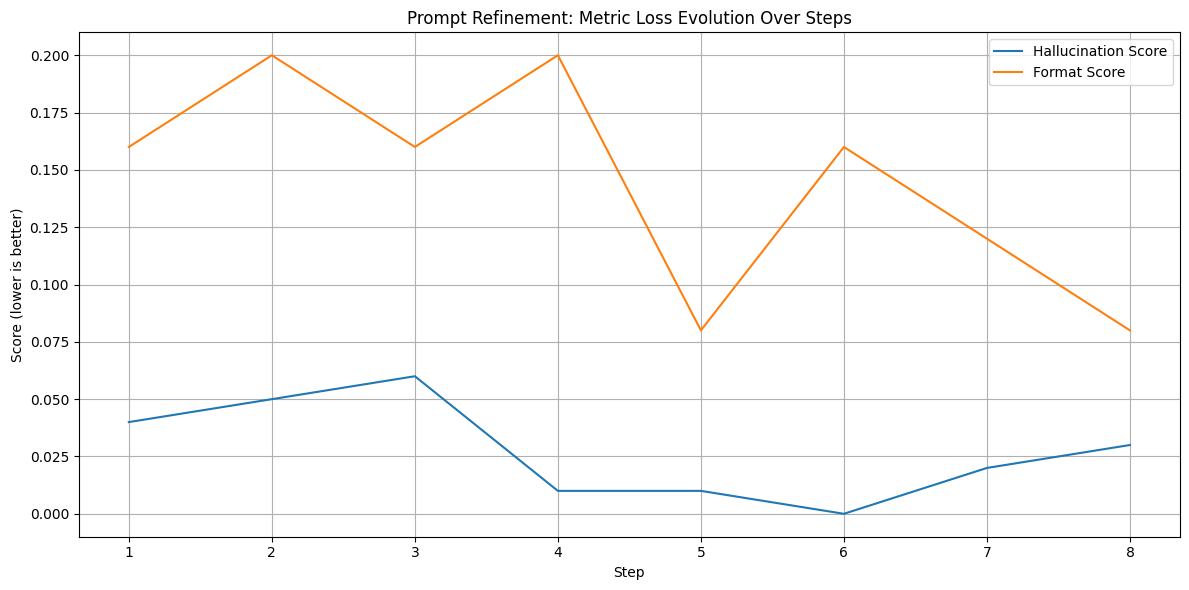

In [184]:
# Unpack the individual scores
avg_scores2 = [s[0] for s in step_scores2[:8]]
hall_scores2 = [s[1] for s in step_scores2[:8]]
fmt_scores2 = [s[2] for s in step_scores2[:8]]
ctx_scores2 = [s[3] for s in step_scores2[:8]]

steps2 = list(range(1, len(step_scores2) + 1))
# plot only first 9 steps
steps2 = steps2[:8]

plt.figure(figsize=(12, 6))
# highlight the average score
#plt.plot(steps2, avg_scores2, marker='o', label='Average Score',  linewidth=2.5, color='black')
# plot all the y range
#plt.fill_between(steps2, 0, 1, color='white', alpha=0.5, label='Score Range (0-1)')
plt.plot(steps2, hall_scores2, label='Hallucination Score', linewidth=1.5)
plt.plot(steps2, fmt_scores2, label='Format Score', linewidth=1.5)
#plt.plot(steps2, ctx_scores2, label='Context Score', linewidth=1.5)
# line at the best score step
best_step_line2 = np.argmin(avg_scores2) + 1
#plt.axvline(best_step_line2, color='red', linestyle='--', label=f'Best Step: {best_step_line2}')

plt.title("Prompt Refinement: Metric Loss Evolution Over Steps")
plt.xlabel("Step")
plt.ylabel("Score (lower is better)")
plt.xticks(steps2)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()